In [1]:
#!pip install langdetect


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import string
from collections import Counter
from bs4 import BeautifulSoup
import seaborn as sns
from langdetect import DetectorFactory, detect

#3. Constructing the Connection Matrix
import networkx as nx
import scipy.sparse as sp

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('vader_lexicon')
#%matplotlib inline

wn = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [2]:
df_twcs = pd.read_csv("/Users/saharawaji/Documents/GitHub/Research/twcs 2.csv", on_bad_lines='skip')
df_twcs

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [3]:
column_names = df_twcs.columns
print(column_names)

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')


### Exploratory Data Analysis (EDA)

In [4]:
# Show information about the dataset
print(df_twcs.info())

#Summary statistics of numerical columns
print(df_twcs.describe())

# Check the first few rows of the dataset
#print(df_twcs.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB
None
           tweet_id  in_response_to_tweet_id
count  2.811774e+06             2.017439e+06
mean   1.504565e+06             1.463141e+06
std    8.616450e+05             8.665730e+05
min    1.000000e+00             1.000000e+00
25%    7.601652e+05             7.155105e+05
50%    1.507772e+06             1.439805e+06
75%    2.253296e+06             2.220646e+06
max    2.987950e+06             2.987950e+06


### Handling Missing Data:



In [5]:
# Drop rows with missing values
df_twcs.dropna(inplace=True)
#print(df_twcs)

In [6]:
X= 2811774 - 976810


In [7]:
# Impute missing values in the 'tweet_id' column with the mean
df_twcs['tweet_id'].fillna(df_twcs['tweet_id'].mean(), inplace=True)


In [8]:
# Count the number of missing values in each column
missing_values_count = df_twcs.isna().sum()


# print count of missing values for each column
print(missing_values_count)


tweet_id                   0
author_id                  0
inbound                    0
created_at                 0
text                       0
response_tweet_id          0
in_response_to_tweet_id    0
dtype: int64


In [9]:
df_twcs

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
...,...,...,...,...,...,...,...
2811718,2987897,VirginTrains,False,Wed Nov 22 06:57:43 +0000 2017,"@136417 Sorry to hear that James, did the the ...",2987898,2987899.0
2811728,2987907,nationalrailenq,False,Thu Nov 30 07:38:44 +0000 2017,London bound trains on the route between Broml...,2987906,2987908.0
2811736,2987915,CoxHelp,False,Thu Nov 30 07:27:11 +0000 2017,"@823858 Hello, this does not sound good. Can...",2987916,2987917.0
2811739,2987918,ArgosHelpers,False,Thu Nov 30 07:58:42 +0000 2017,@823859 Hi Natalie that doesn't sound good. Ca...,2987919,2987920.0


In [10]:
X = 2811774 - 976810

X

1834964

We start to do my resarch 


In [11]:
#`created_at` is in the format "Tue Oct 31 22:10:47 +0000 2017"

df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_twcs

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0
5,6,sprintcare,False,2017-10-31 21:46:24,@115712 Can you please send us a private messa...,"5,7",8.0
...,...,...,...,...,...,...,...
2811718,2987897,VirginTrains,False,2017-11-22 06:57:43,"@136417 Sorry to hear that James, did the the ...",2987898,2987899.0
2811728,2987907,nationalrailenq,False,2017-11-30 07:38:44,London bound trains on the route between Broml...,2987906,2987908.0
2811736,2987915,CoxHelp,False,2017-11-30 07:27:11,"@823858 Hello, this does not sound good. Can...",2987916,2987917.0
2811739,2987918,ArgosHelpers,False,2017-11-30 07:58:42,@823859 Hi Natalie that doesn't sound good. Ca...,2987919,2987920.0


### We want to creates a new column in df_twcs named week_number and assigns to it the week number extracted from the created_at datetime values.

In [12]:
# Extracting week of year
df_twcs['week_number'] = df_twcs['created_at'].dt.isocalendar().week

df_twcs

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,week_number
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0,44
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,44
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0,44
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,44
5,6,sprintcare,False,2017-10-31 21:46:24,@115712 Can you please send us a private messa...,"5,7",8.0,44
...,...,...,...,...,...,...,...,...
2811718,2987897,VirginTrains,False,2017-11-22 06:57:43,"@136417 Sorry to hear that James, did the the ...",2987898,2987899.0,47
2811728,2987907,nationalrailenq,False,2017-11-30 07:38:44,London bound trains on the route between Broml...,2987906,2987908.0,48
2811736,2987915,CoxHelp,False,2017-11-30 07:27:11,"@823858 Hello, this does not sound good. Can...",2987916,2987917.0,48
2811739,2987918,ArgosHelpers,False,2017-11-30 07:58:42,@823859 Hi Natalie that doesn't sound good. Ca...,2987919,2987920.0,48


In [13]:
# Calculate the number of unique weeks in my dataset 
unique_weeks_count = df_twcs['week_number'].nunique()

print(f'There are {unique_weeks_count} unique weeks in the dataset.')


There are 53 unique weeks in the dataset.


In [14]:
# Filter for the first week
#1. Filter the DataFrame for the First Week

first_week_data = df_twcs[df_twcs['week_number'] == df_twcs['week_number'].min()]
first_week_data


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,week_number
20788,26822,Safaricom_Care,False,2017-01-05 13:49:33,@121879 We have been in touch.^EO,26821,26823.0,1
20789,26823,121879,True,2017-01-05 13:31:16,@Safaricom_Care please contact me. 0796898600,26822,26824.0,1
20790,26824,Safaricom_Care,False,2017-01-05 13:08:43,@121879 We have been in touch .^EO,26823,26825.0,1
20791,26825,121879,True,2017-01-05 12:56:51,@Safaricom_Care Activate this number 079689860...,26824,26826.0,1
155259,185842,AppleSupport,False,2017-01-03 13:11:29,@159710 We're here for you. Which iPhone and s...,185841,185843.0,1
...,...,...,...,...,...,...,...,...
2436494,2605663,737228,True,2017-01-06 04:53:47,@SpotifyCares done! thanks for the reply 😌,2605661,2605664.0,1
2471170,1309640,airtel_care,False,2017-01-02 22:20:13,"Hello @426055, please be informed that the bun...",2640877,1309639.0,1
2492374,2662198,YahooCare,False,2014-12-29 17:11:22,"@750318 Hi David, Our Accounts team can help y...",2662199,2662200.0,1
2492376,2662200,750318,True,2014-12-29 13:13:07,"@YahooCare Hi thanks for the reply, I've tried...",2662198,2662201.0,1


In [15]:
# 2. Create an Edge List for the First Week
# Create an edge list
edge_list = first_week_data[['author_id', 'in_response_to_tweet_id']].dropna()
edge_list

,author_id,in_response_to_tweet_id
20788,Safaricom_Care,26823.0
20789,121879,26824.0
20790,Safaricom_Care,26825.0
20791,121879,26826.0
155259,AppleSupport,185843.0
...,...,...
2436494,737228,2605664.0
2471170,airtel_care,1309639.0
2492374,YahooCare,2662200.0
2492376,750318,2662201.0


In [16]:
# Initialize a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in edge_list.iterrows():
    G.add_edge(row['author_id'], row['in_response_to_tweet_id'])
    
# Analyzing the Graph
# Convert to adjacency matrix (be cautious with large graphs)
adj_matrix = nx.adjacency_matrix(G)
adj_matrix

<100x100 sparse array of type '<class 'numpy.int64'>'
	with 63 stored elements in Compressed Sparse Row format>

In [17]:
dense_matrix = adj_matrix.todense()

# Print the dense matrix
print(dense_matrix)


[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


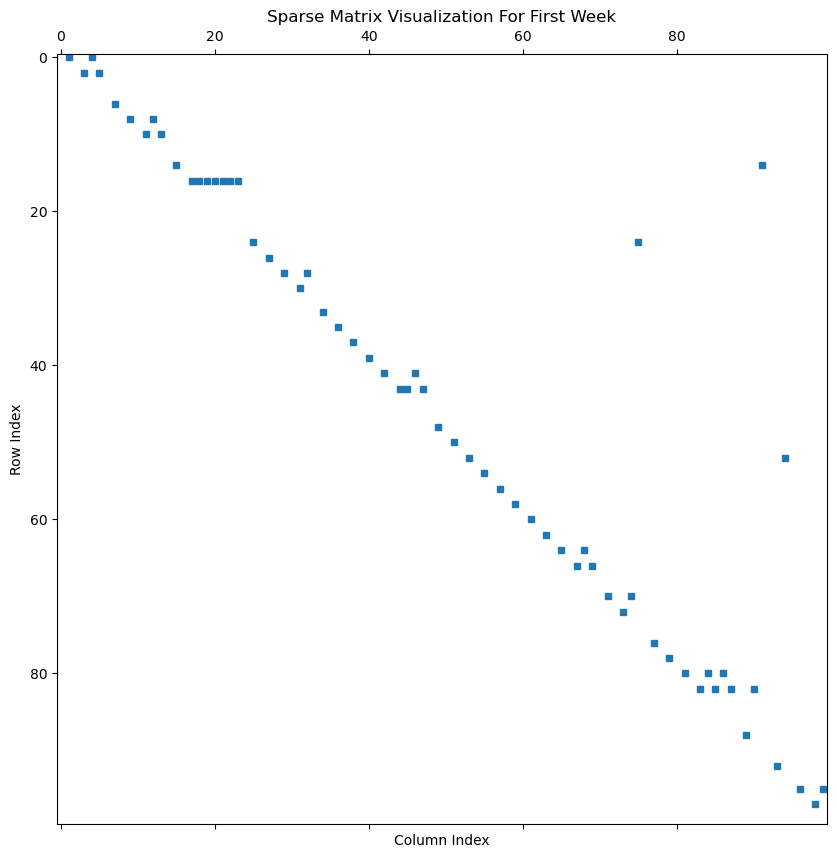

In [18]:
#plot
plt.figure(figsize=(10, 10))
plt.spy(adj_matrix, markersize=5)
plt.title('Sparse Matrix Visualization For First Week')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


In [19]:
# We use the SentimentIntensityAnalyzer backage 
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# function to get the sentiment category
def get_sentiment_category(text):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to your DataFrame
first_week_data['sentiment'] = first_week_data['text'].apply(get_sentiment_category)

sentiment_counts = first_week_data['sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


sentiment
Positive    53.968254
Neutral     34.920635
Negative    11.111111
Name: proportion, dtype: float64


/var/folders/b8/2pryzbwn1td3r1t1_lld8qnm0000gn/T/ipykernel_86737/1783586032.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week_data['sentiment'] = first_week_data['text'].apply(get_sentiment_category)


### For all my data 

In [20]:
unique_weeks = df_twcs['week_number'].unique()
# Convert to a NumPy array and sort
unique_weeks = np.sort(unique_weeks)

# Placeholder for your matrices or any other week-specific analysis results
weekly_matrices = {}

for week in unique_weeks:
    # Filter the DataFrame for the current week
    week_data = df_twcs[df_twcs['week_number'] == week]
    
    # Assuming 'author_id' and 'in_response_to_tweet_id' represent the connections
    edge_list = week_data[['author_id', 'in_response_to_tweet_id']].dropna()
    
    # For demonstration, let's print the size of the DataFrame for each week
    print(f"Week {week}: {len(week_data)} tweets")


Week 1: 63 tweets
Week 2: 78 tweets
Week 3: 68 tweets
Week 4: 35 tweets
Week 5: 50 tweets
Week 6: 60 tweets
Week 7: 79 tweets
Week 8: 81 tweets
Week 9: 52 tweets
Week 10: 50 tweets
Week 11: 49 tweets
Week 12: 52 tweets
Week 13: 100 tweets
Week 14: 106 tweets
Week 15: 68 tweets
Week 16: 105 tweets
Week 17: 80 tweets
Week 18: 79 tweets
Week 19: 123 tweets
Week 20: 95 tweets
Week 21: 124 tweets
Week 22: 114 tweets
Week 23: 131 tweets
Week 24: 115 tweets
Week 25: 107 tweets
Week 26: 183 tweets
Week 27: 143 tweets
Week 28: 159 tweets
Week 29: 208 tweets
Week 30: 229 tweets
Week 31: 264 tweets
Week 32: 294 tweets
Week 33: 434 tweets
Week 34: 371 tweets
Week 35: 530 tweets
Week 36: 763 tweets
Week 37: 1042 tweets
Week 38: 1670 tweets
Week 39: 4833 tweets
Week 40: 67207 tweets
Week 41: 109537 tweets
Week 42: 110934 tweets
Week 43: 114933 tweets
Week 44: 115705 tweets
Week 45: 104026 tweets
Week 46: 104370 tweets
Week 47: 114315 tweets
Week 48: 122359 tweets
Week 49: 62 tweets
Week 50: 71 tweet

In [21]:

# Placeholder for storing matrices or graphs
weekly_graphs = {}

for week_number in unique_weeks:
    week_data = df_twcs[df_twcs['week_number'] == week_number]
    # Create a graph for the week
    G = nx.from_pandas_edgelist(week_data, 'author_id', 'in_response_to_tweet_id', create_using=nx.DiGraph())
    
    # Add the graph to your collection
    weekly_graphs[week_number] = G
    


In [22]:

# Dictionary to hold adjacency matrices for each week
weekly_adj_matrices = {}

for week in unique_weeks:
    # Filter data for the current week
    week_data = df_twcs[df_twcs['week_number'] == week]
    
    # Create a directed graph for the week
    G_week = nx.from_pandas_edgelist(
        week_data.dropna(subset=['in_response_to_tweet_id']),  
        source='author_id', 
        target='in_response_to_tweet_id', 
        create_using=nx.DiGraph()
    )
    
    # Generate adjacency matrix for the graph
    adj_matrix = nx.adjacency_matrix(G_week)
    
    # Store the adjacency matrix with the corresponding week as the key
    weekly_adj_matrices[week] = adj_matrix
    
    
    print(f"Week {week} - Nodes: {G_week.number_of_nodes()}, Edges: {G_week.number_of_edges()}")

    
for week, adj_matrix in weekly_adj_matrices.items():
    # Convert sparse matrix to dense matrix
    dense_matrix = adj_matrix.todense()
    
    print(f"Week {week} - Adjacency Matrix:")
    print(dense_matrix)
    print("\n")  # Add a newline for better separation between weeks


Week 1 - Nodes: 100, Edges: 63
Week 2 - Nodes: 121, Edges: 78
Week 3 - Nodes: 107, Edges: 68
Week 4 - Nodes: 53, Edges: 35
Week 5 - Nodes: 79, Edges: 49
Week 6 - Nodes: 94, Edges: 60
Week 7 - Nodes: 116, Edges: 79
Week 8 - Nodes: 115, Edges: 81
Week 9 - Nodes: 81, Edges: 52
Week 10 - Nodes: 78, Edges: 50
Week 11 - Nodes: 77, Edges: 49
Week 12 - Nodes: 77, Edges: 52
Week 13 - Nodes: 146, Edges: 100
Week 14 - Nodes: 162, Edges: 106
Week 15 - Nodes: 105, Edges: 68
Week 16 - Nodes: 159, Edges: 105
Week 17 - Nodes: 115, Edges: 80
Week 18 - Nodes: 124, Edges: 79
Week 19 - Nodes: 176, Edges: 123
Week 20 - Nodes: 143, Edges: 94
Week 21 - Nodes: 180, Edges: 124
Week 22 - Nodes: 159, Edges: 114
Week 23 - Nodes: 191, Edges: 131
Week 24 - Nodes: 172, Edges: 115
Week 25 - Nodes: 164, Edges: 107
Week 26 - Nodes: 258, Edges: 183
Week 27 - Nodes: 213, Edges: 143
Week 28 - Nodes: 233, Edges: 159
Week 29 - Nodes: 306, Edges: 206
Week 30 - Nodes: 339, Edges: 229
Week 31 - Nodes: 363, Edges: 264
Week 32 -

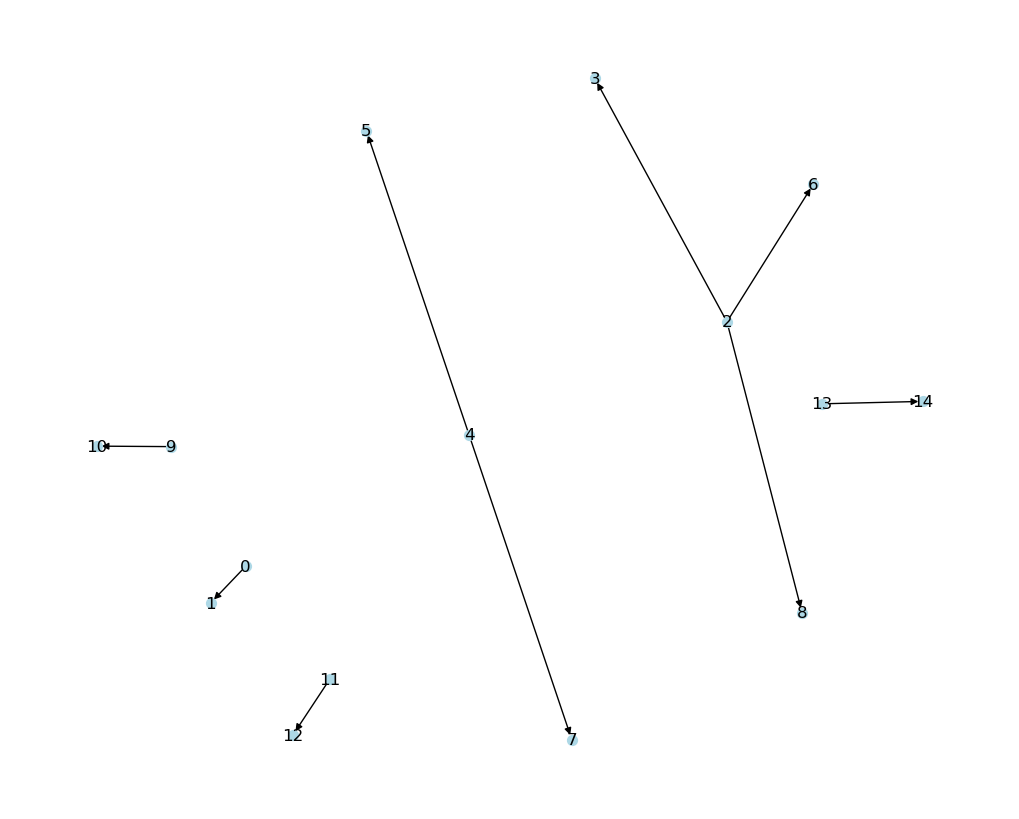

In [23]:

G_week = nx.DiGraph()

cx = weekly_adj_matrices[week].tocoo()  

for i, j, v in zip(cx.row, cx.col, cx.data):
    if v != 0:  # 'v' represents the existence of an edge 
        G_week.add_edge(i, j)

plt.figure(figsize=(10, 8))
nx.draw(G_week, with_labels=True, node_size=50, node_color="lightblue", arrows=True)
plt.show()


In [24]:
# We use the SentimentIntensityAnalyzer backage 
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# function to get the sentiment category
def get_sentiment_category(text):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to your DataFrame
df_twcs['sentiment'] = df_twcs['text'].apply(get_sentiment_category)

sentiment_counts = df_twcs['sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


sentiment
Positive    48.554274
Neutral     29.147122
Negative    22.298605
Name: proportion, dtype: float64


In [ ]:
As you know 

Step 1: Convert created_at to Datetime and Extract Week Number
Step 2: Identify Unique Weeks
Step 3: Create a Graph for Each Week
Step 4: Calculate Degree Distribution and Plot


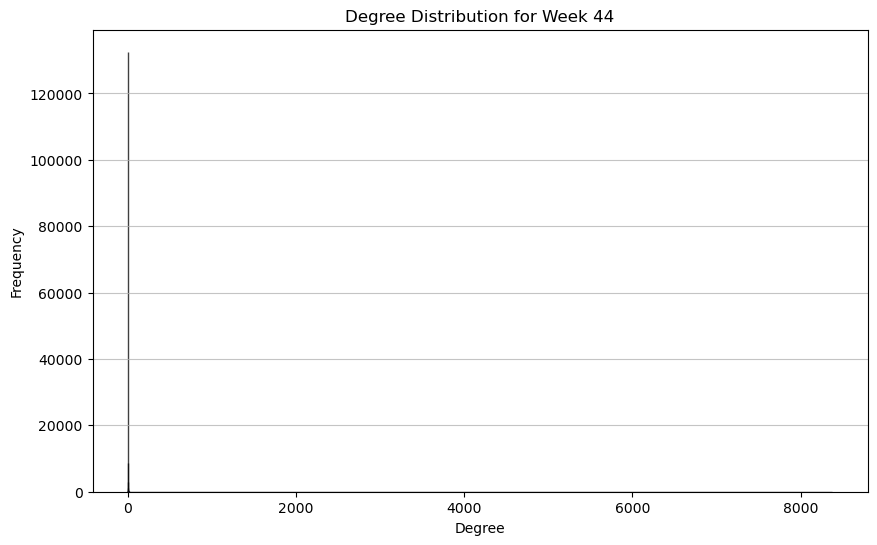

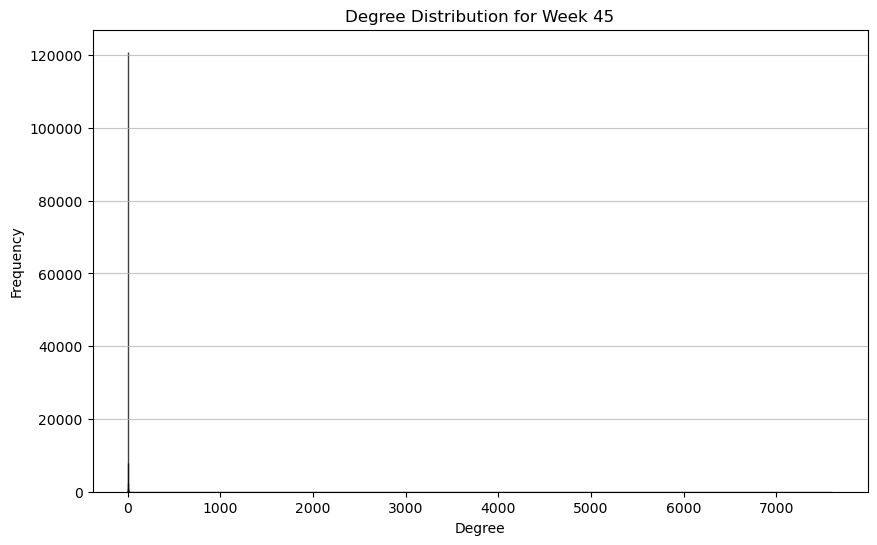

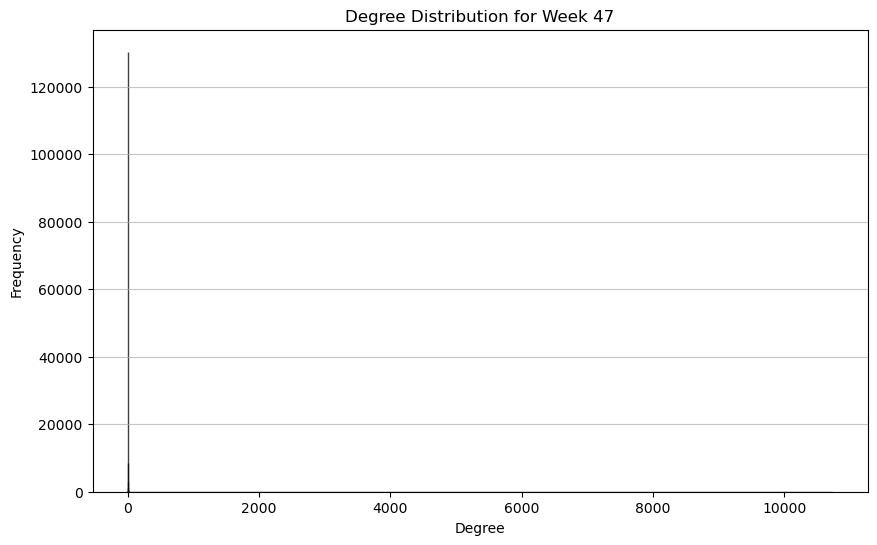

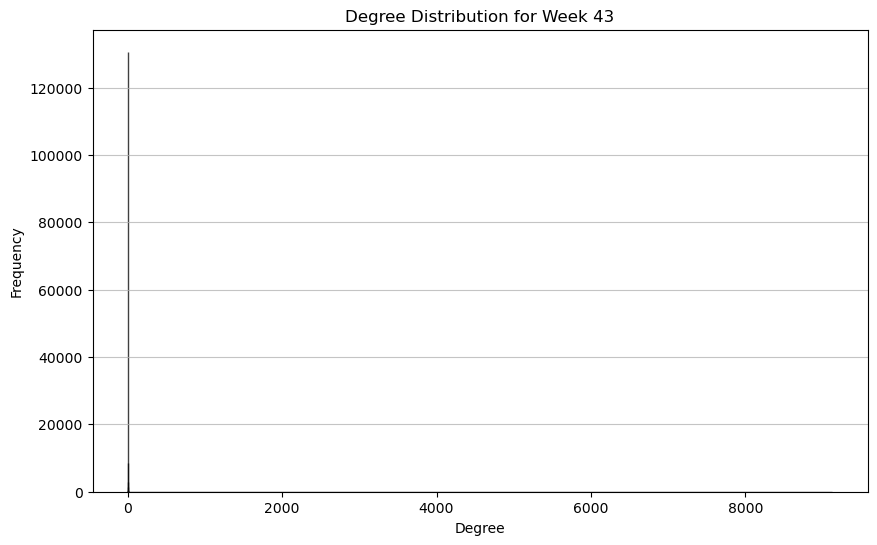

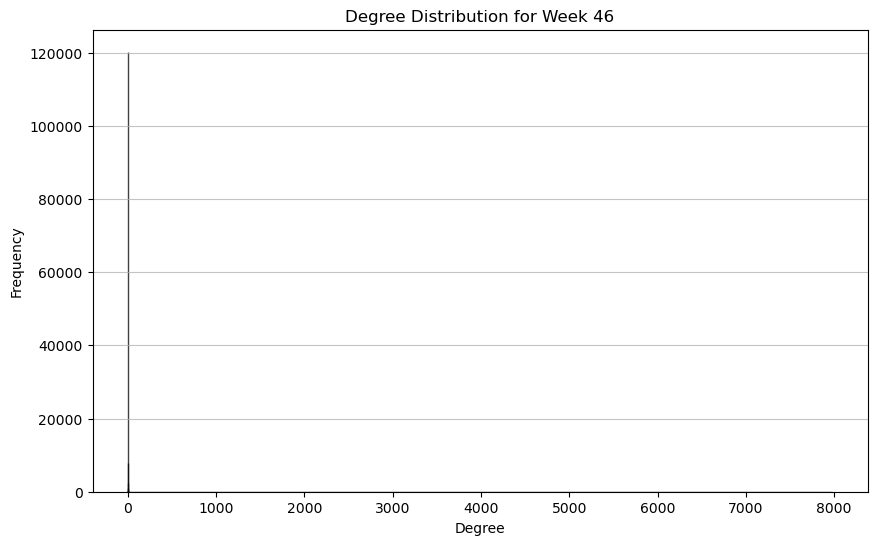

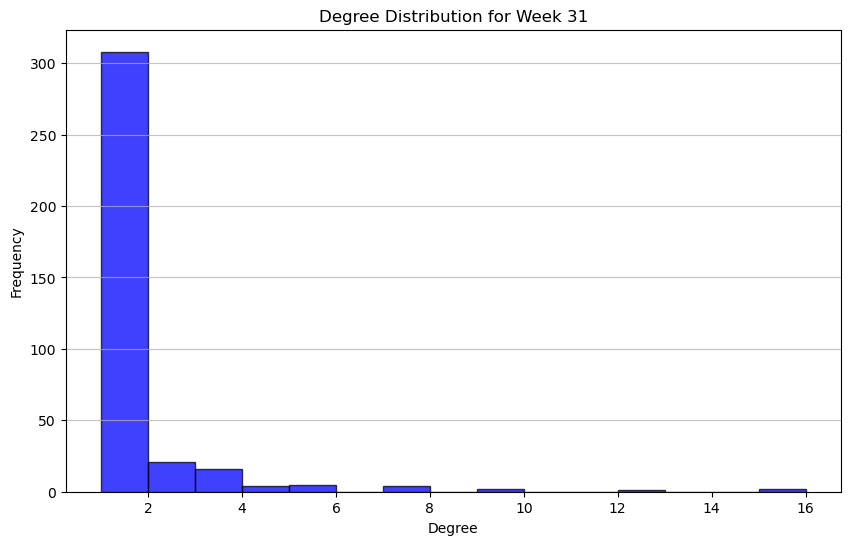

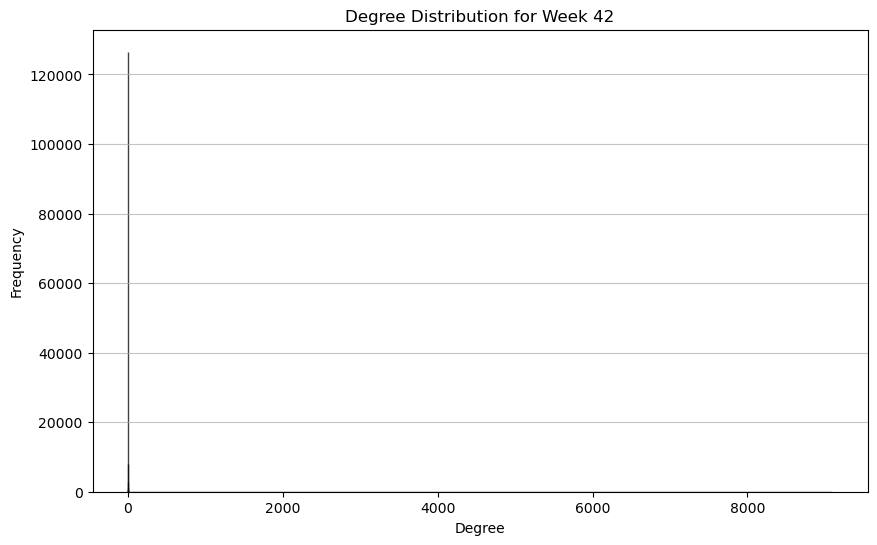

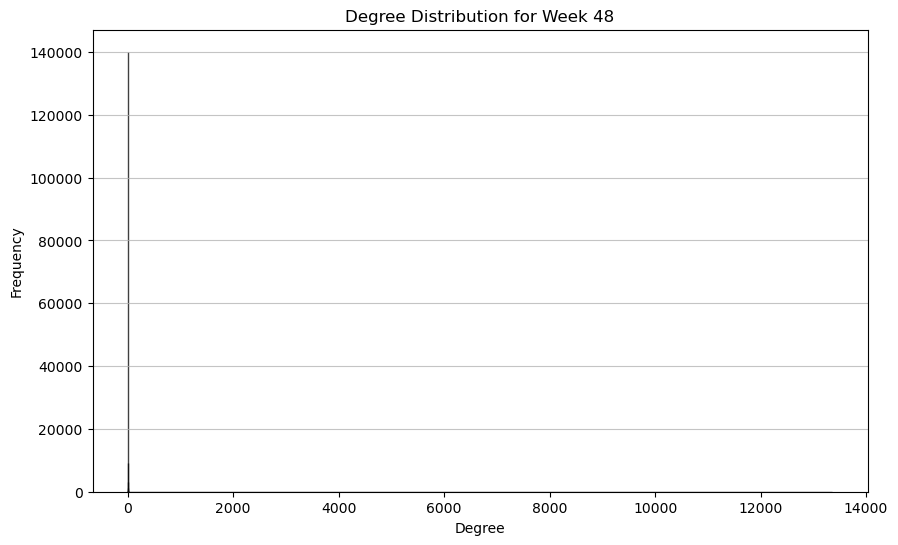

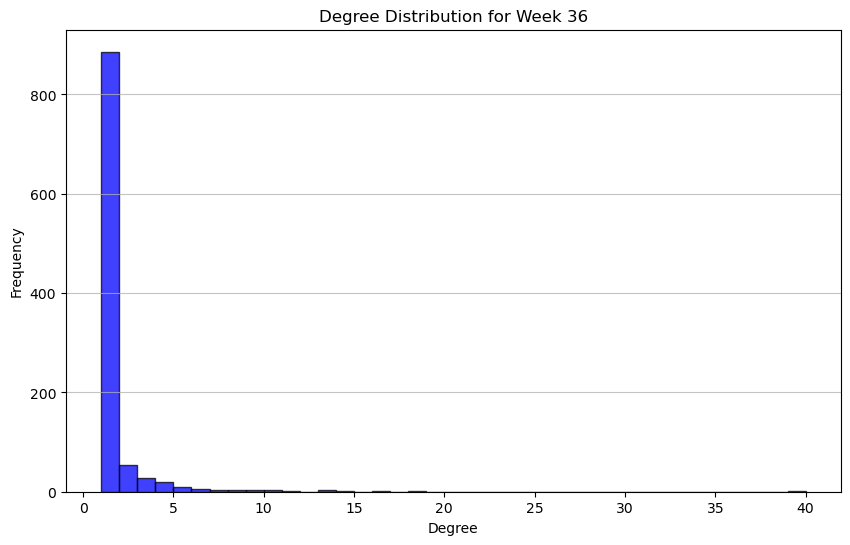

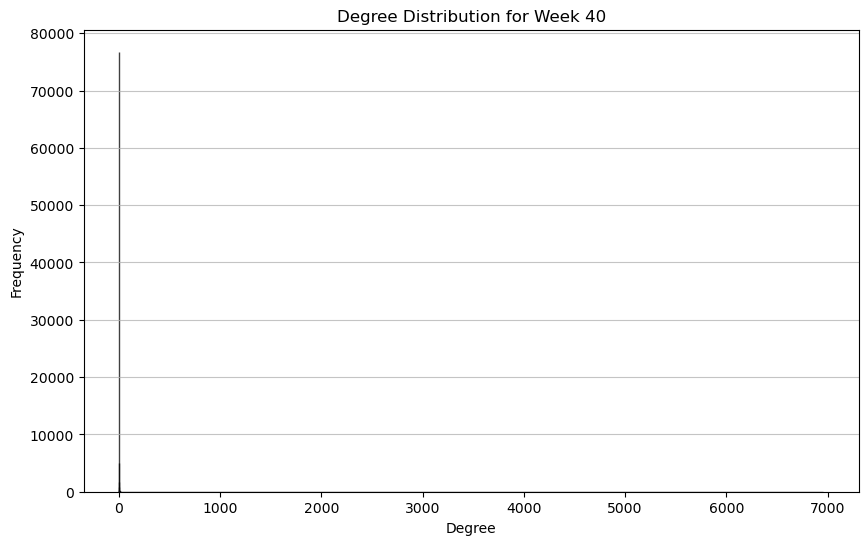

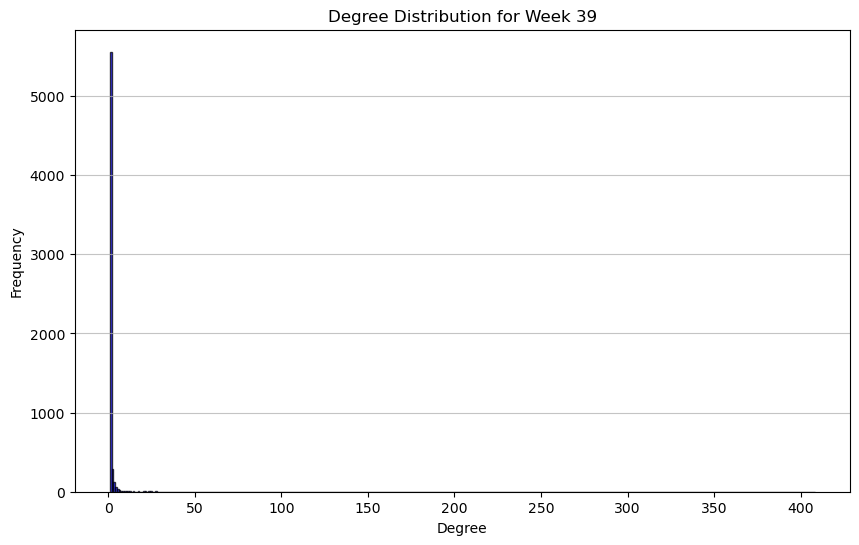

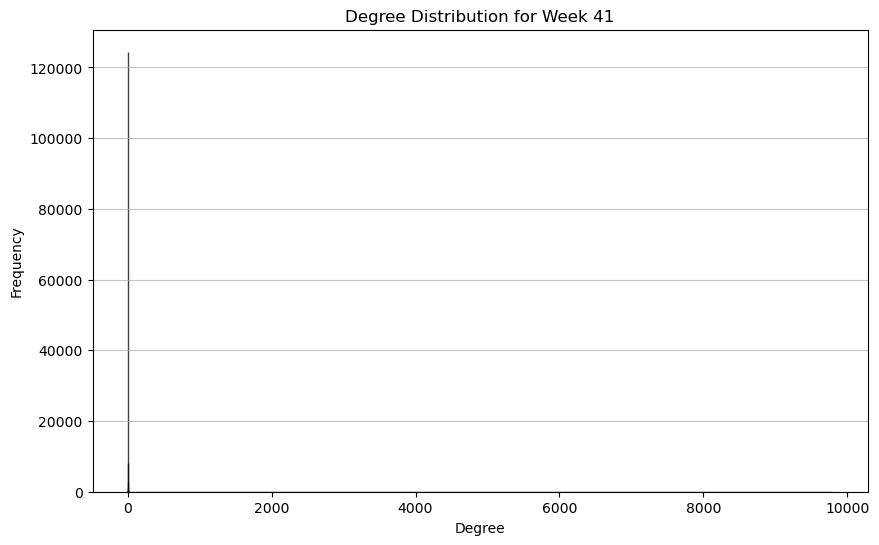

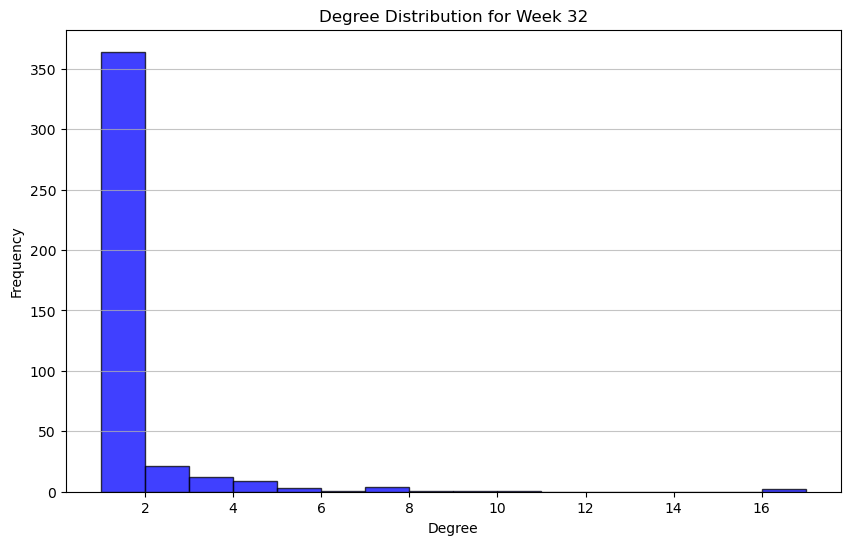

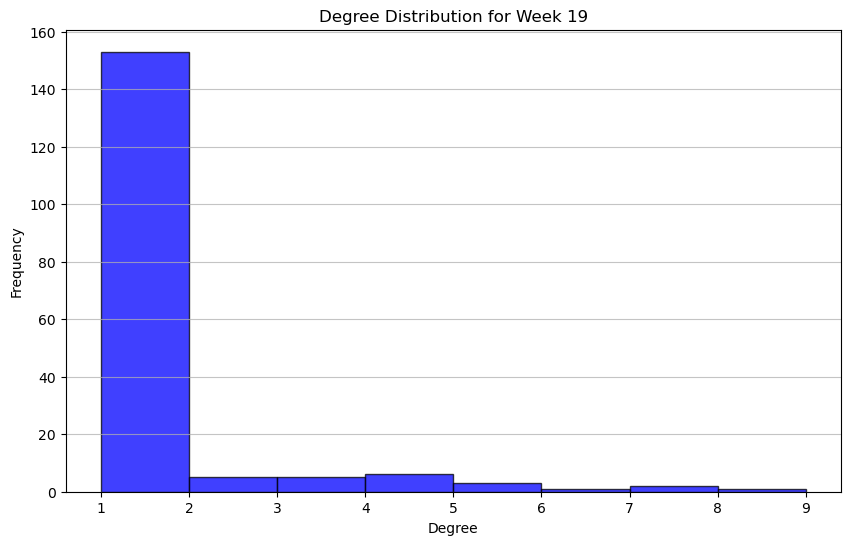

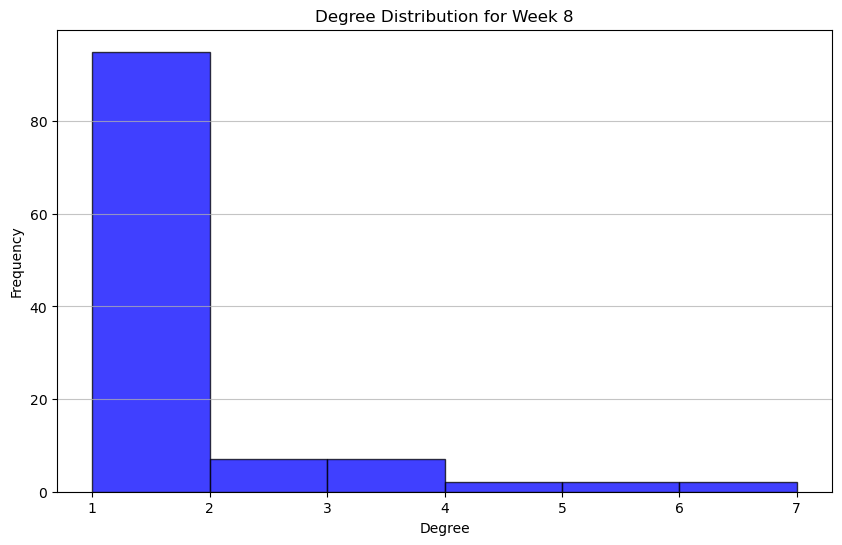

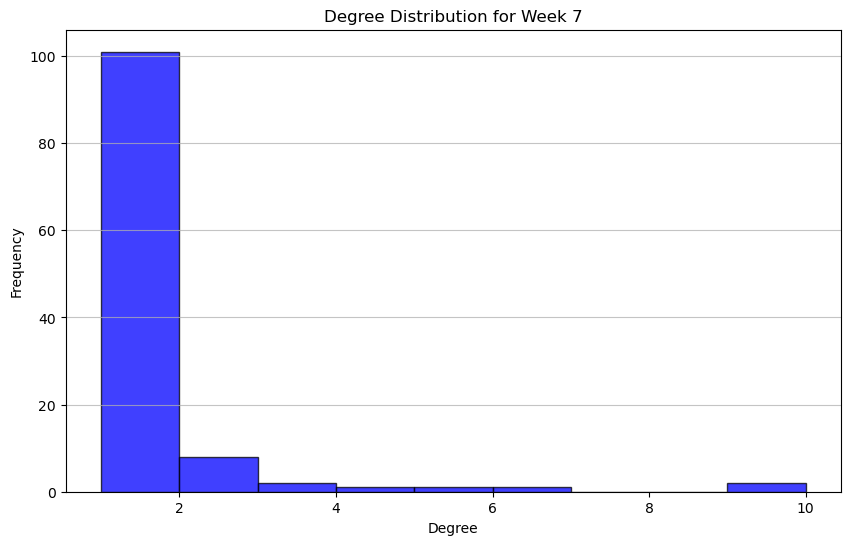

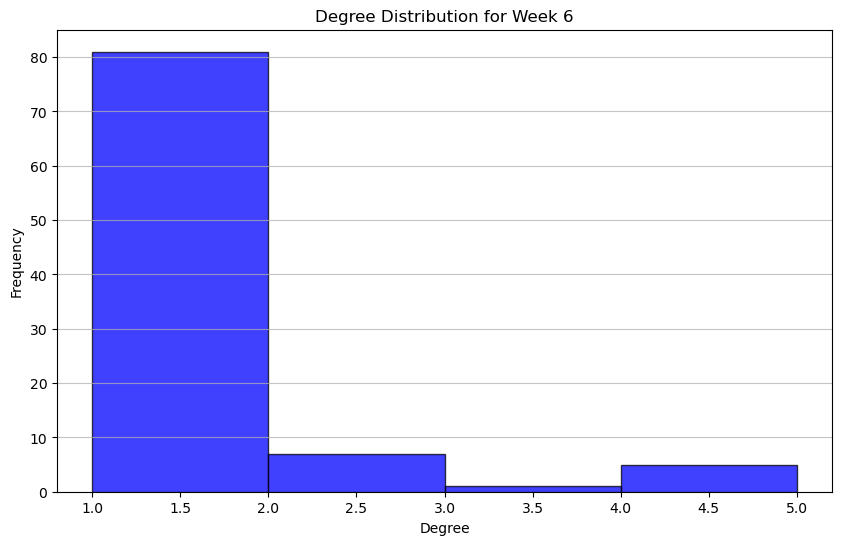

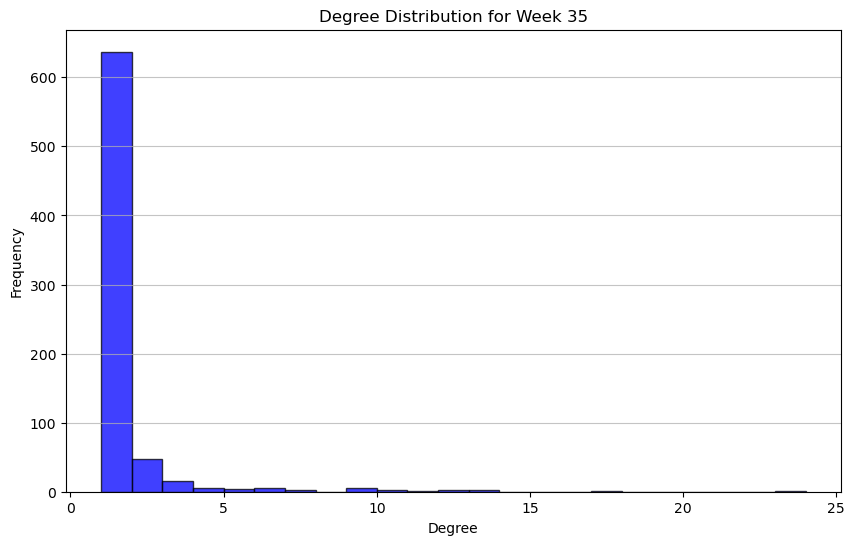

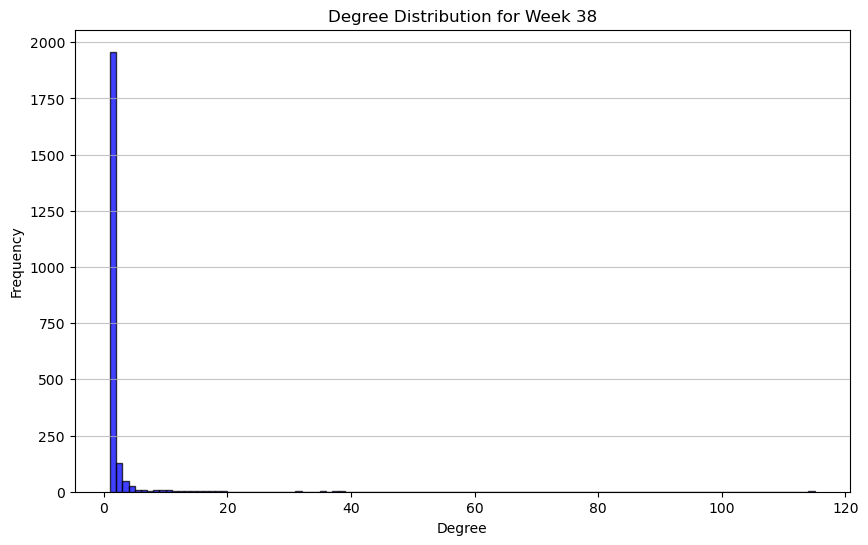

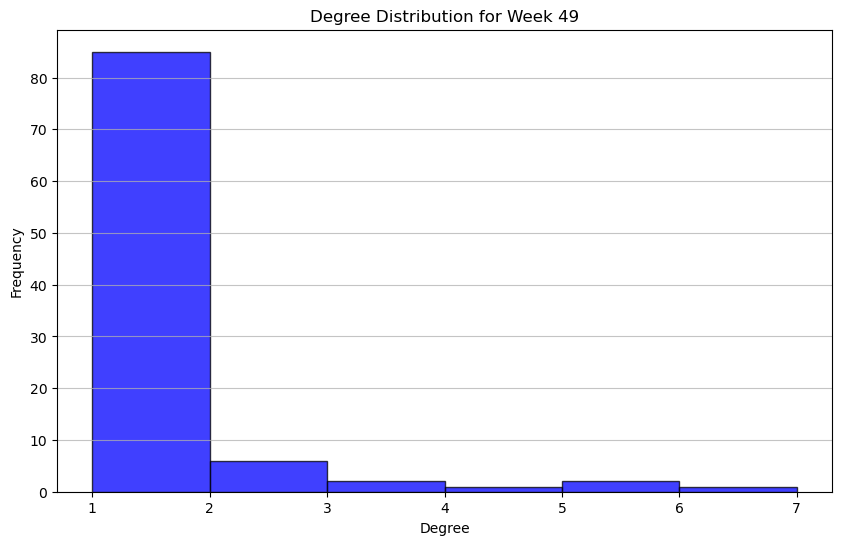

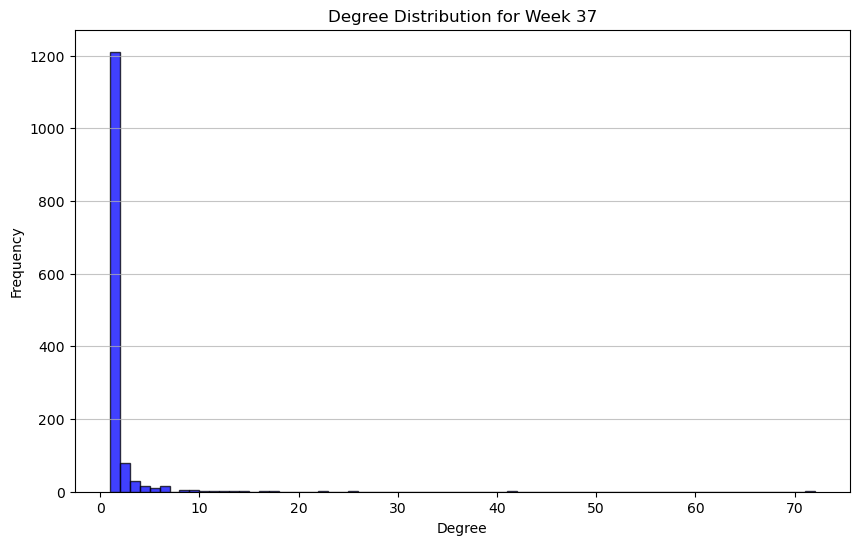

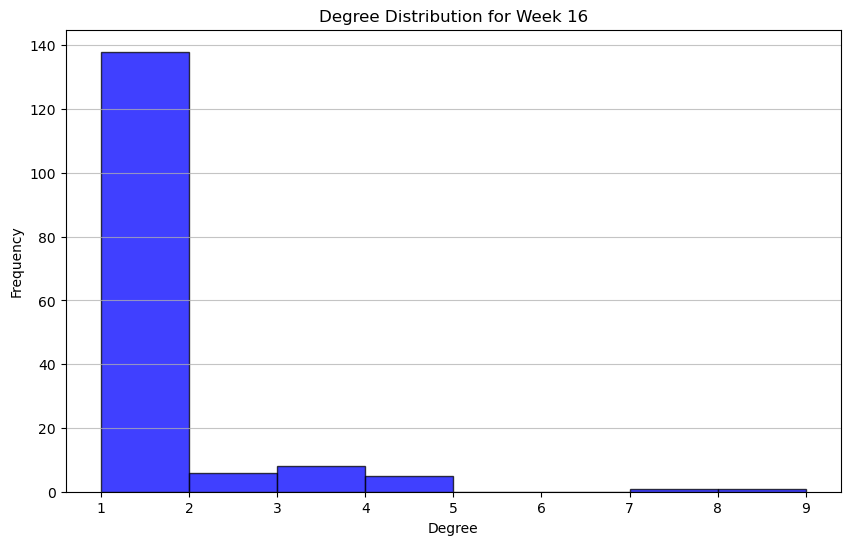

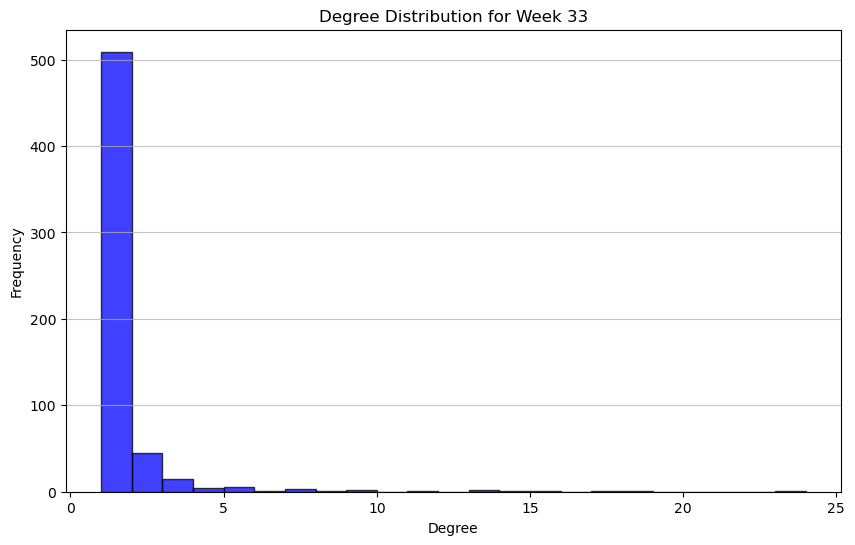

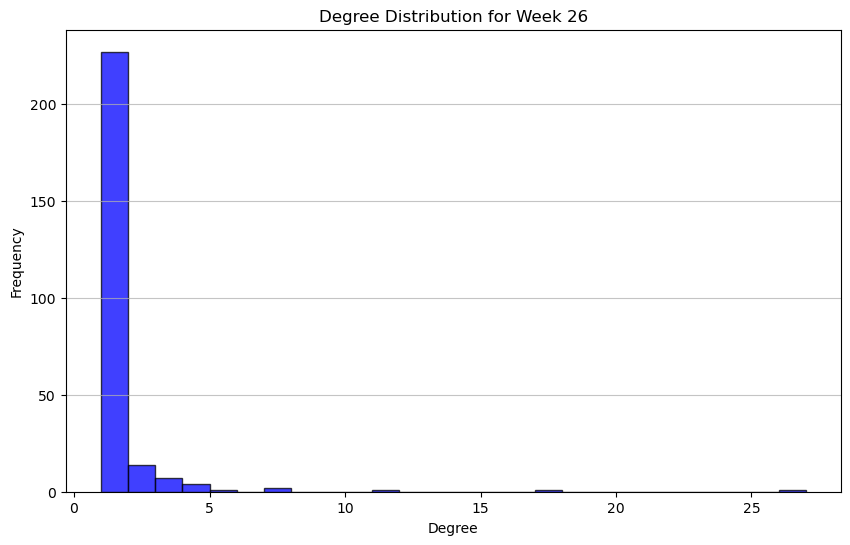

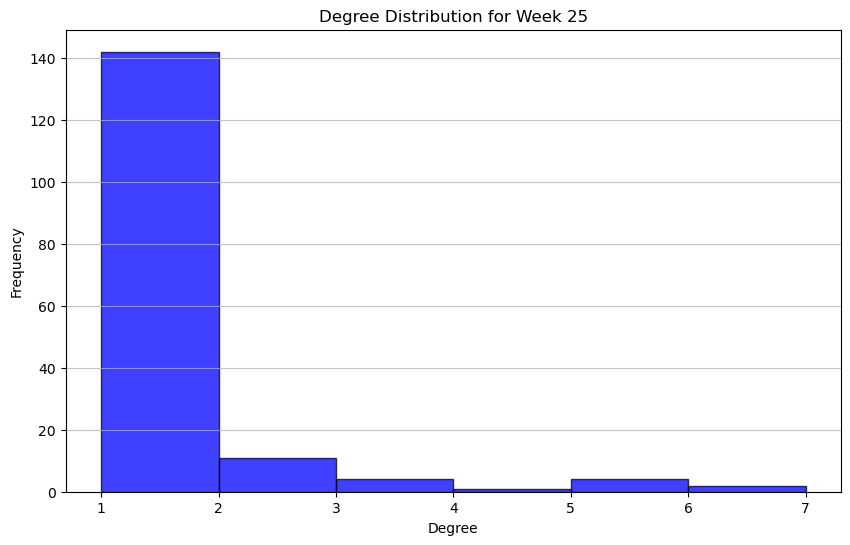

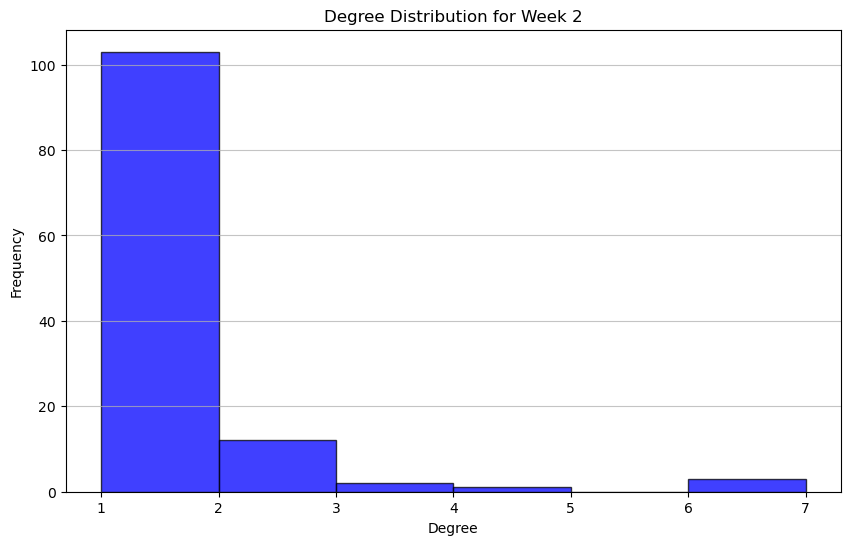

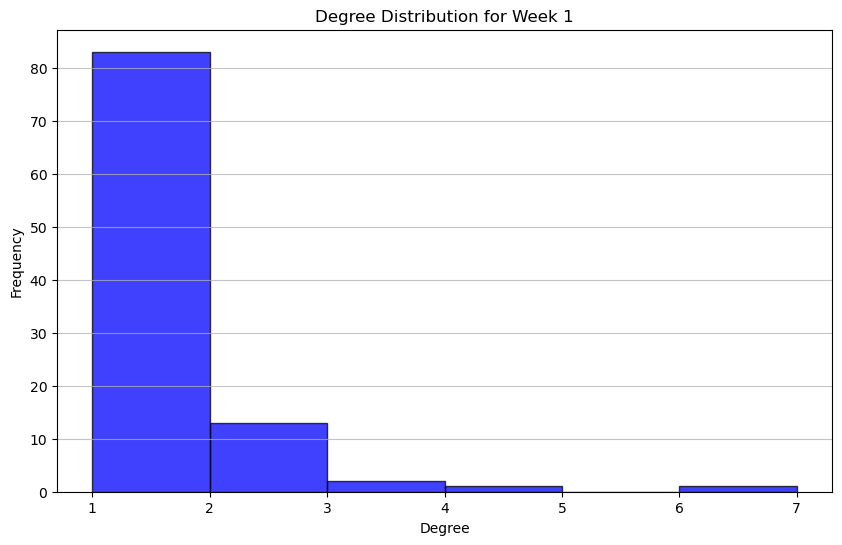

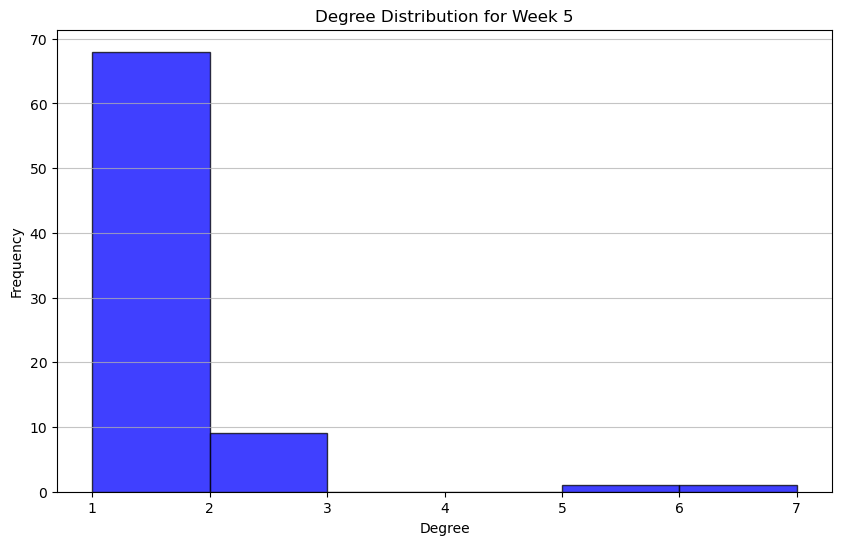

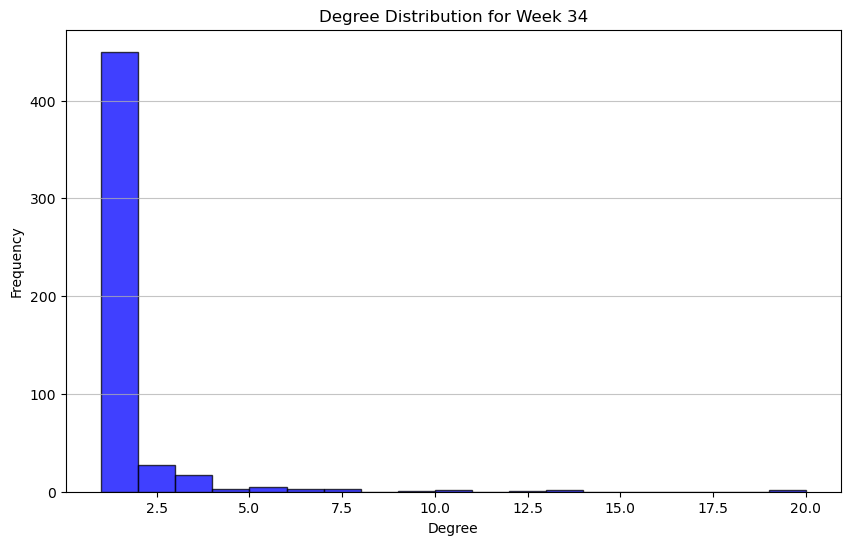

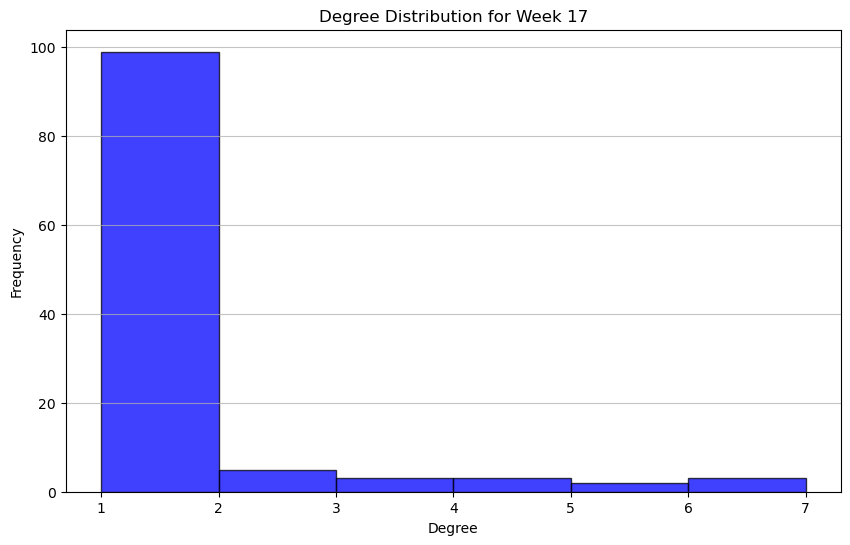

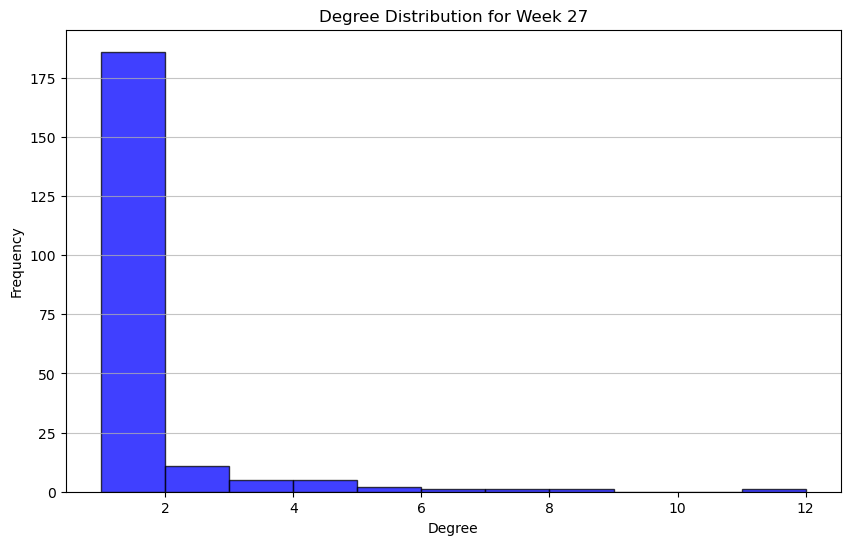

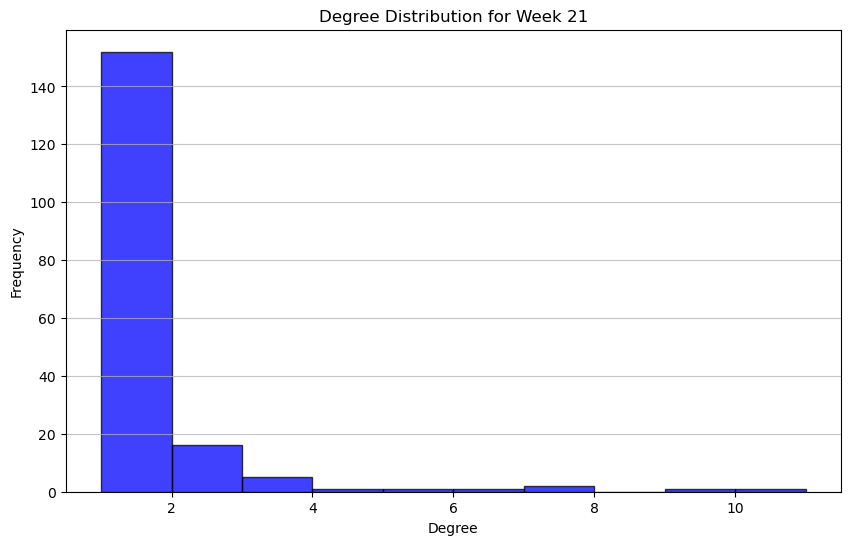

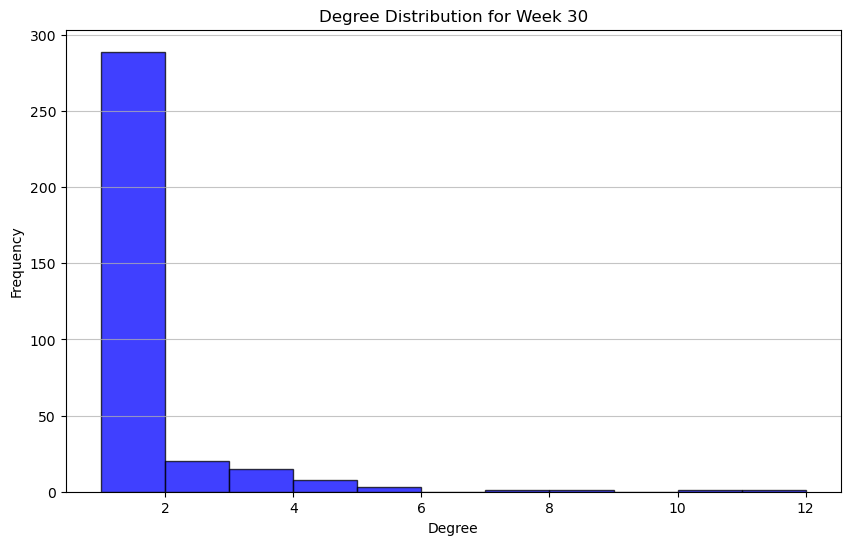

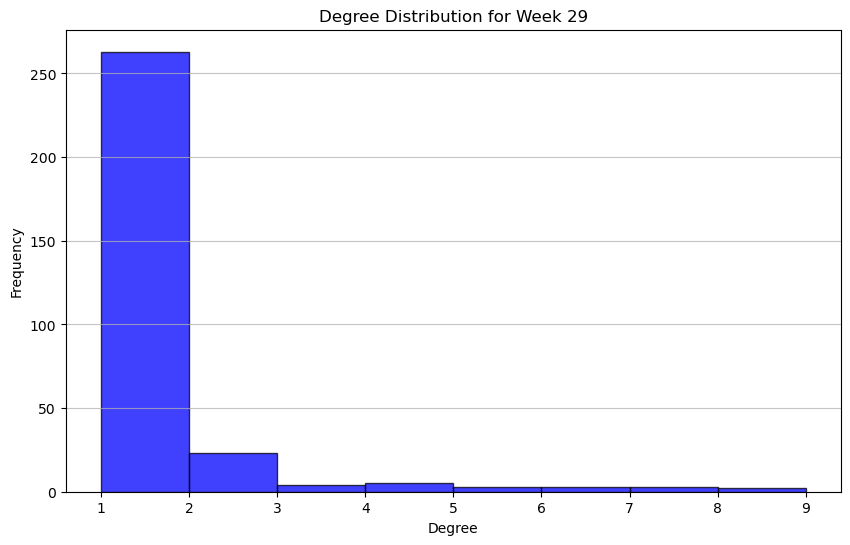

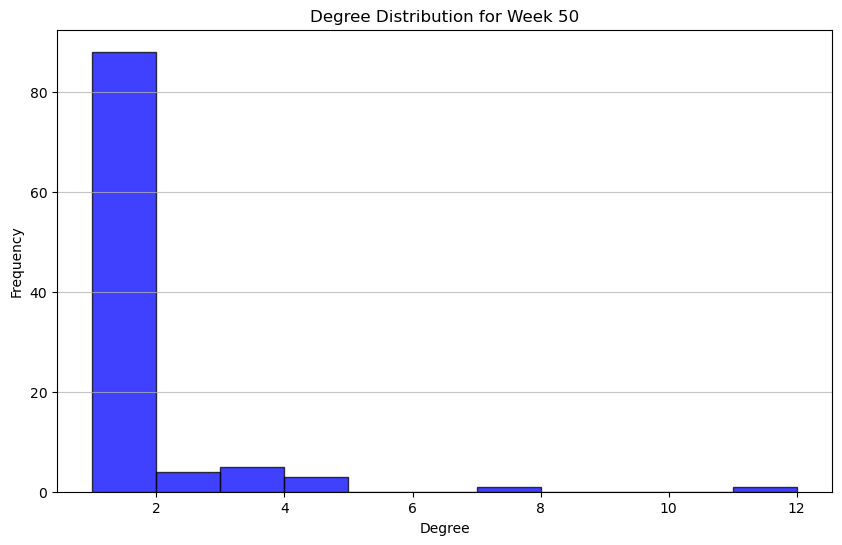

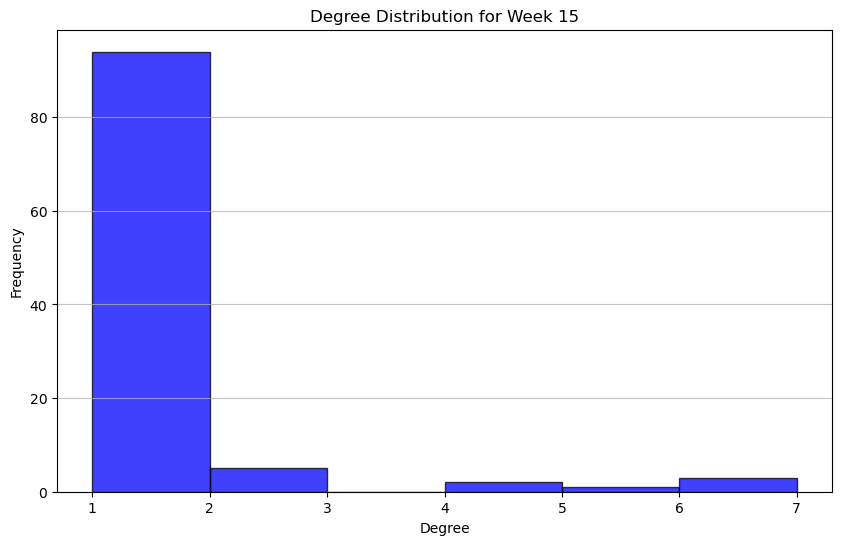

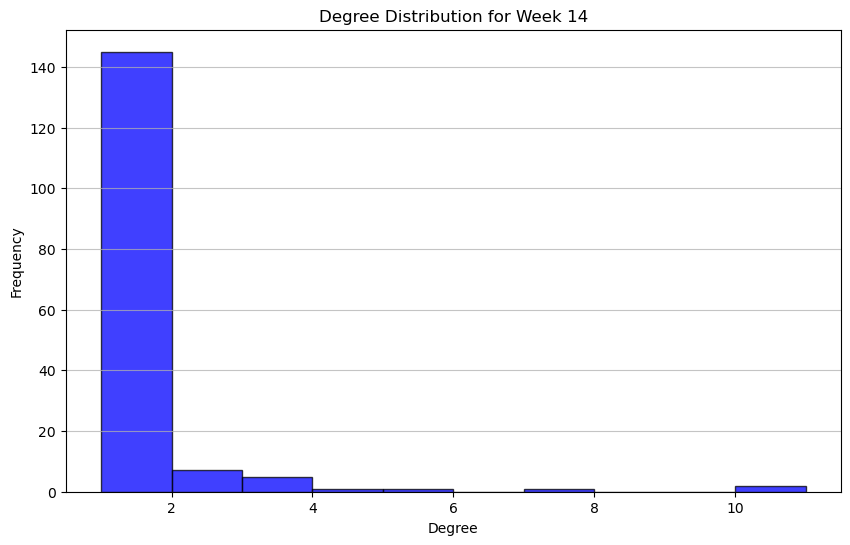

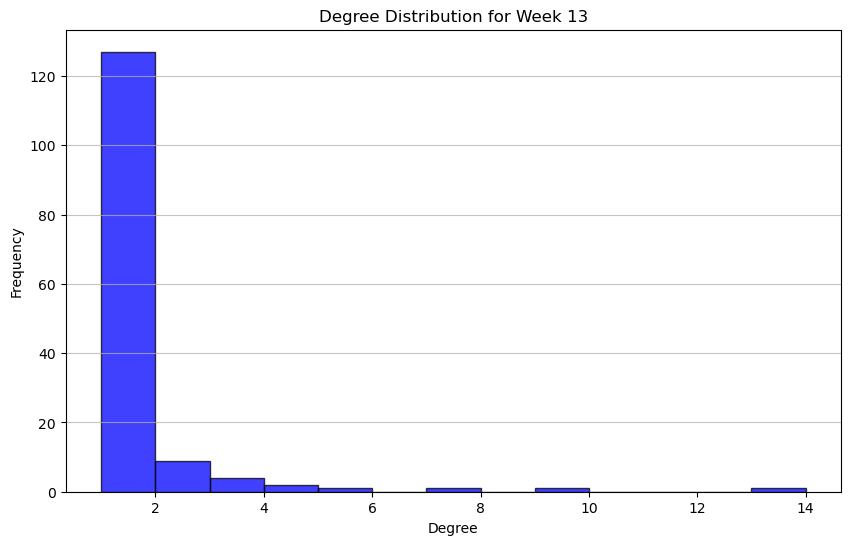

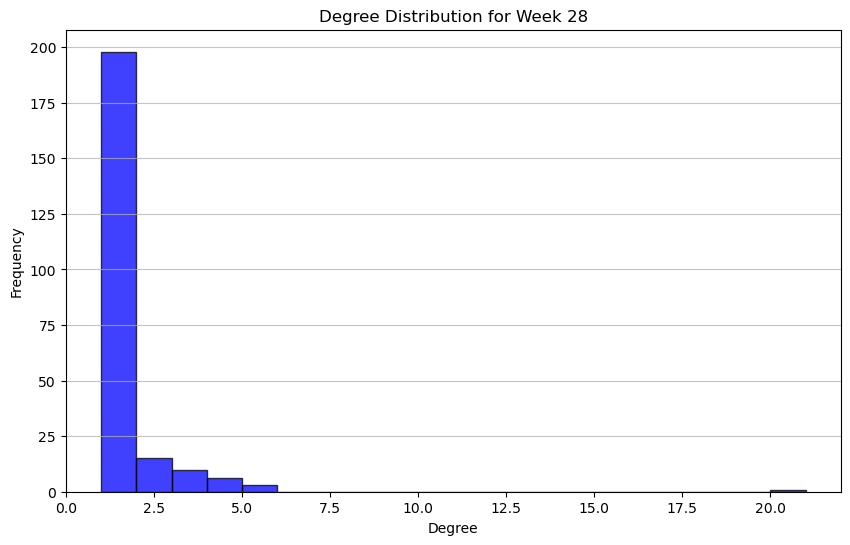

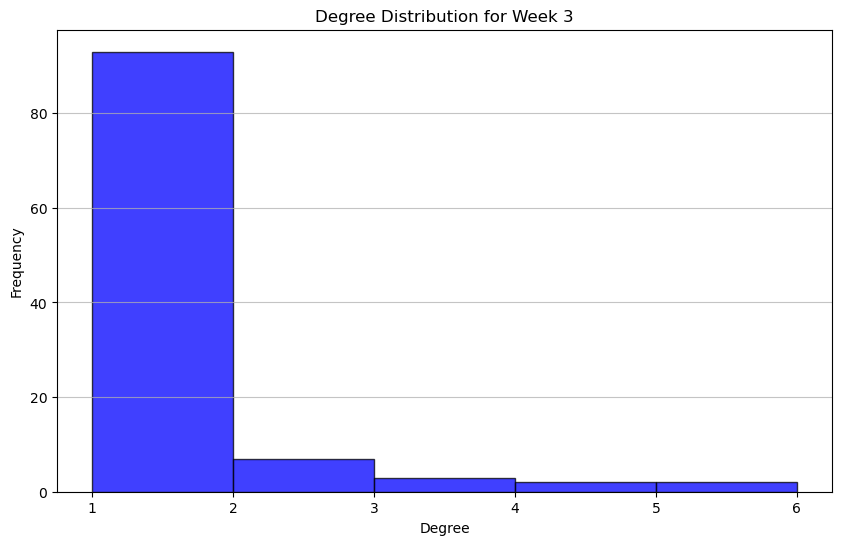

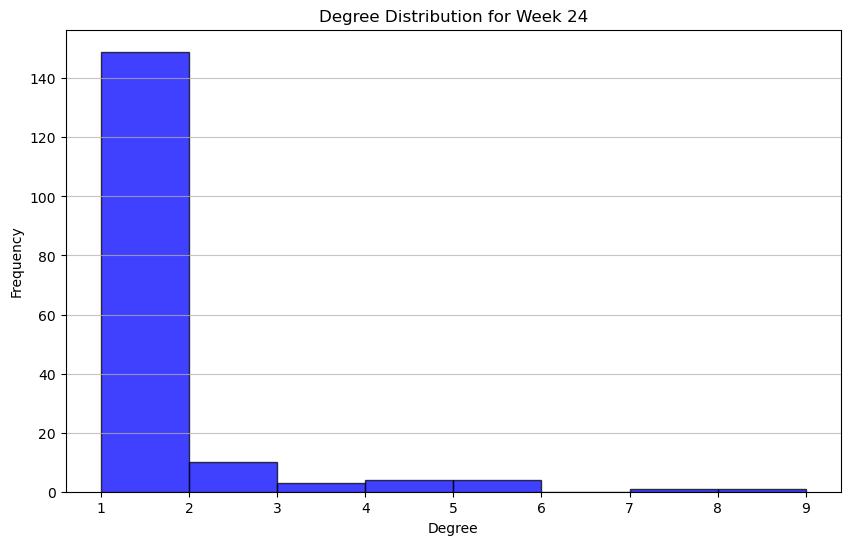

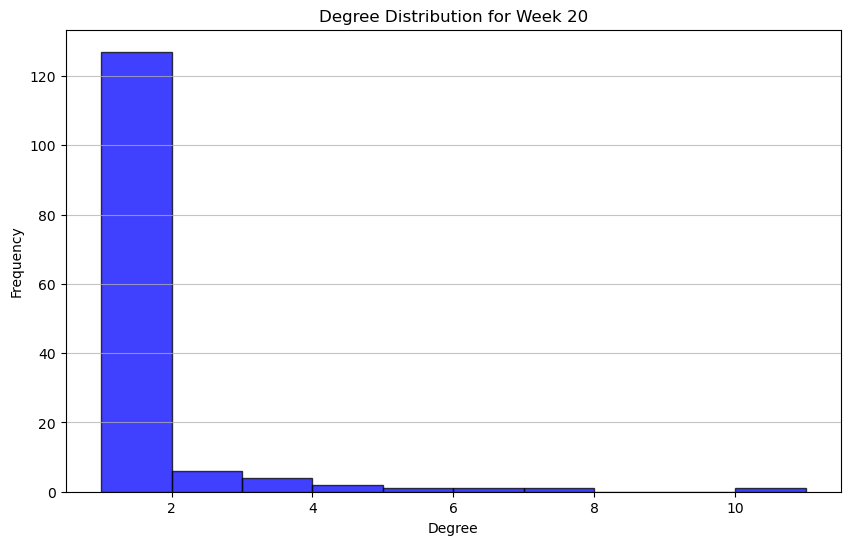

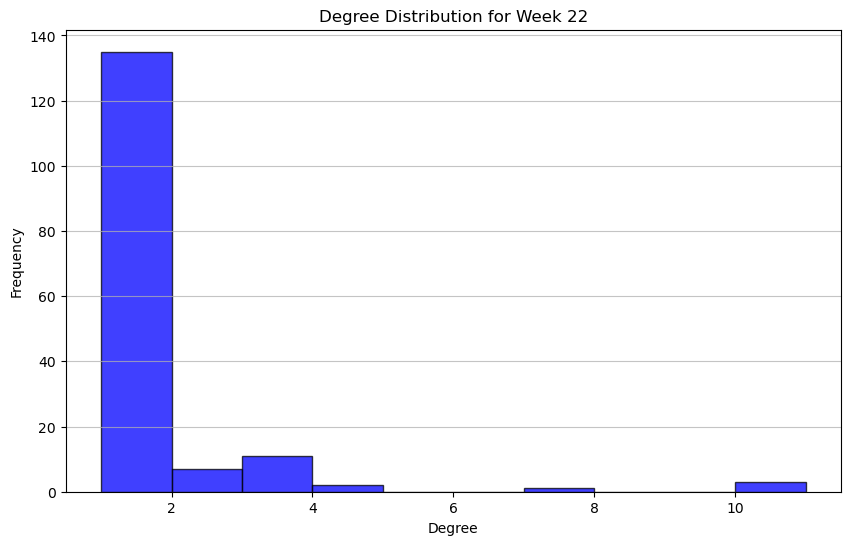

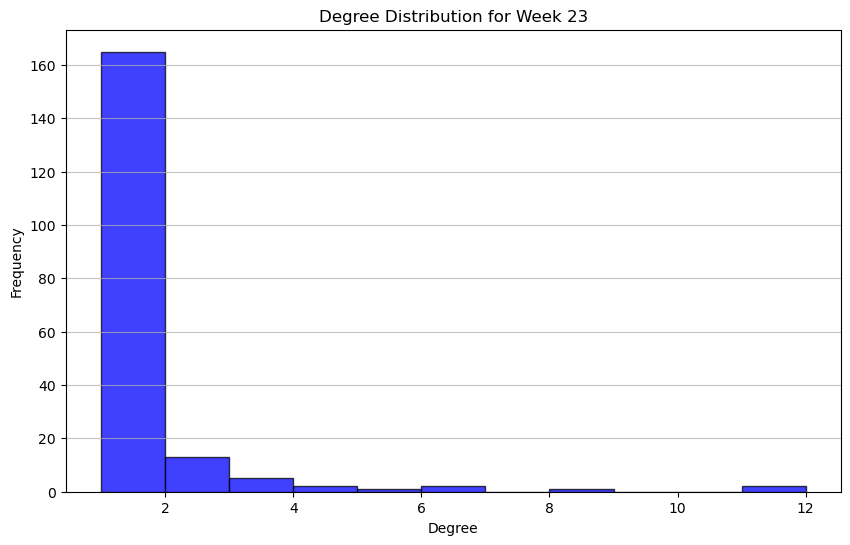

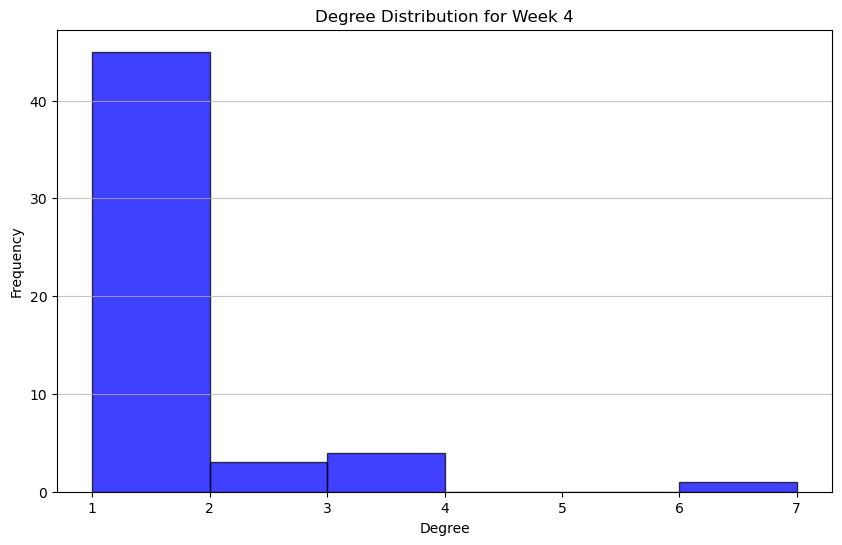

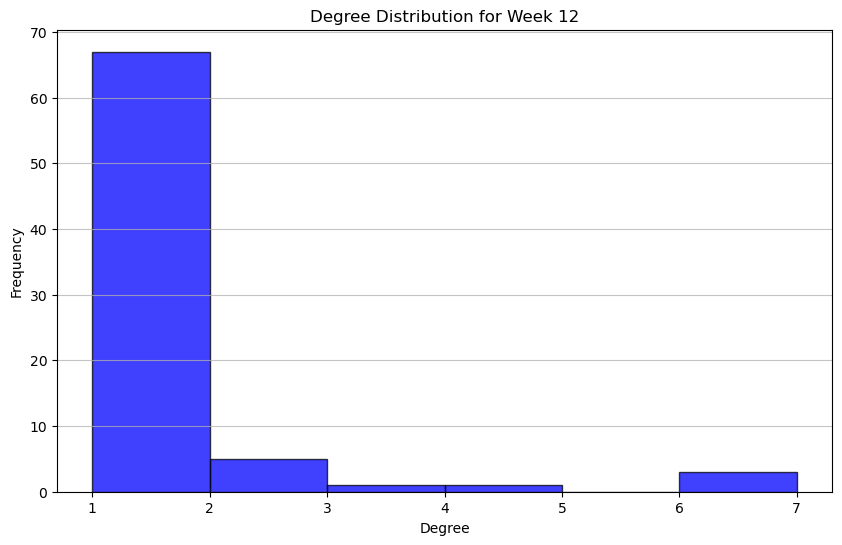

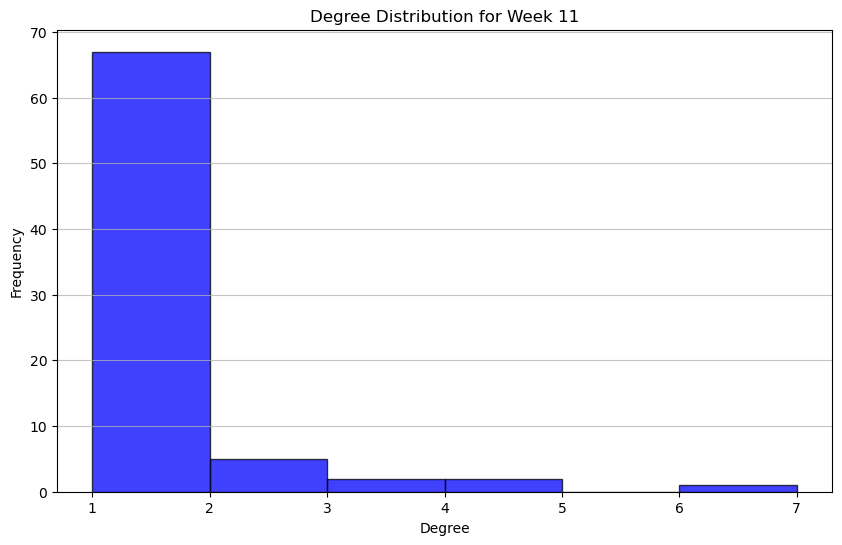

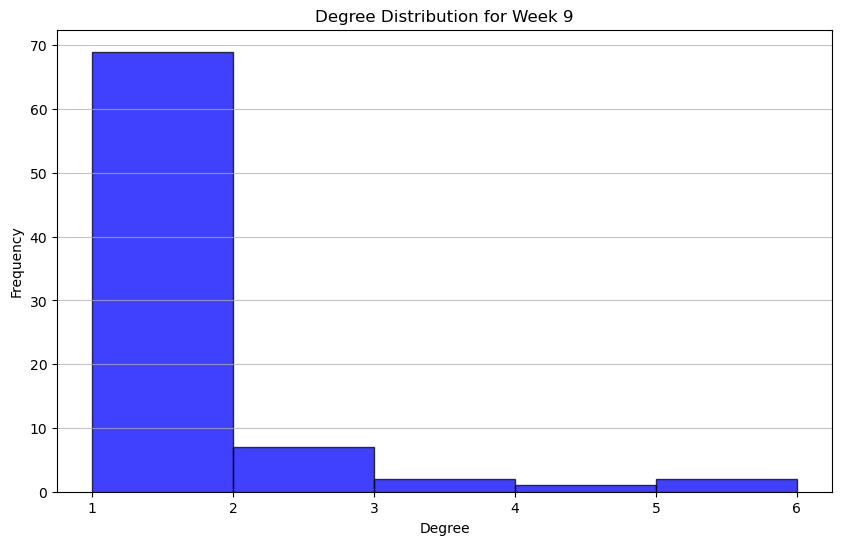

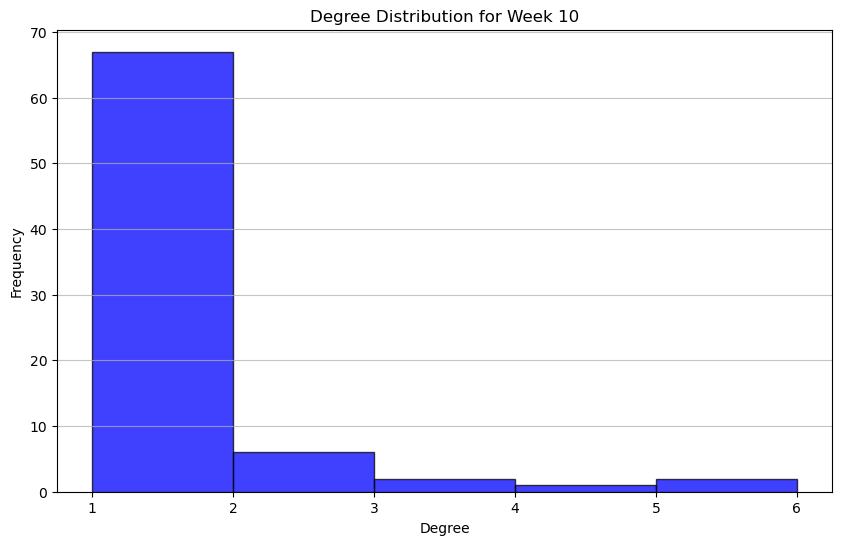

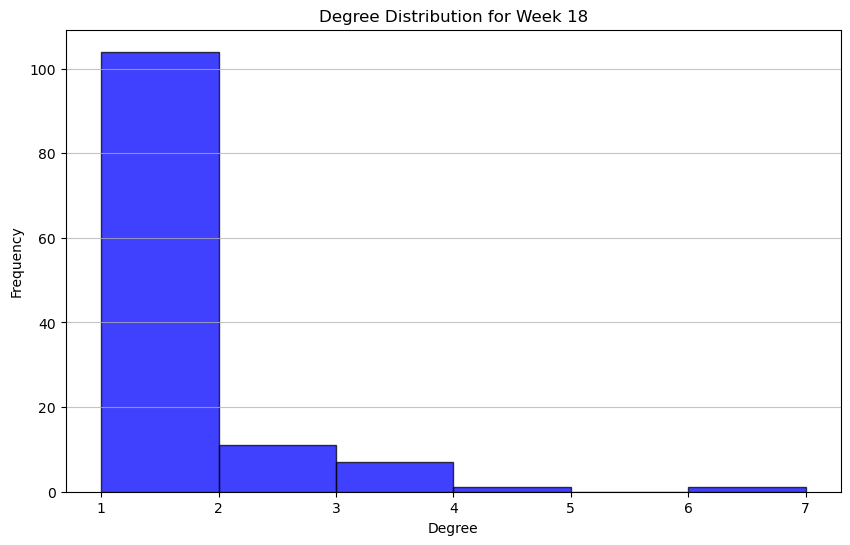

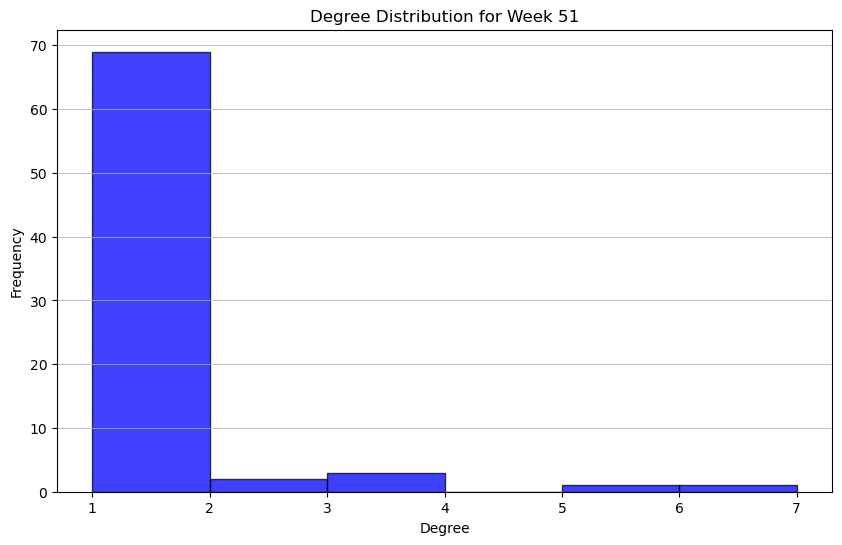

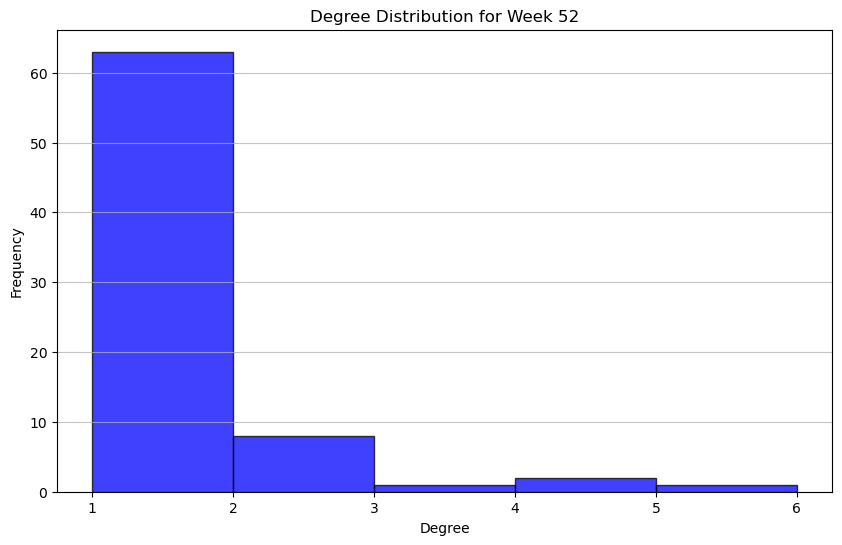

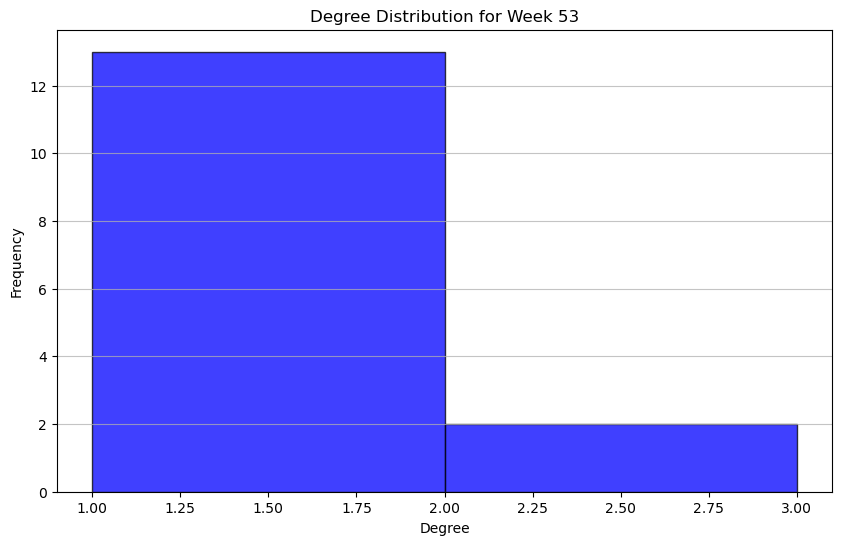

In [28]:
#Step 1: Convert created_at to Datetime and Extract Week Number

df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_twcs['week_number'] = df_twcs['created_at'].dt.isocalendar().week

#Step 2: Identify Unique Weeks

unique_weeks = df_twcs['week_number'].unique()

#Step 3: Create a Graph for Each Week

# Dictionary to store the graph for each week
weekly_graphs = {}

for week in unique_weeks:
    # Filter the DataFrame for the current week
    week_data = df_twcs[df_twcs['week_number'] == week]
    
    # Assuming 'author_id' represents nodes and 'in_response_to_tweet_id' represents edges
    # Adjust these column names based on your actual data schema
    G = nx.from_pandas_edgelist(week_data.dropna(subset=['in_response_to_tweet_id']),
                                source='author_id', target='in_response_to_tweet_id',
                                create_using=nx.DiGraph())
    
    # Store the graph with the week number as the key
    weekly_graphs[week] = G

#Step 4:Calculate Degree Distribution and Plot


# Iterate through each week's graph
for week, G in weekly_graphs.items():
    # Calculate the degree of each node
    degrees = [G.degree(n) for n in G.nodes()]
    
    # Plot the degree distribution as a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), alpha=0.75, color='blue', edgecolor='black')
    
    plt.title(f'Degree Distribution for Week {week}')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    
    # Show the plot
    plt.show()



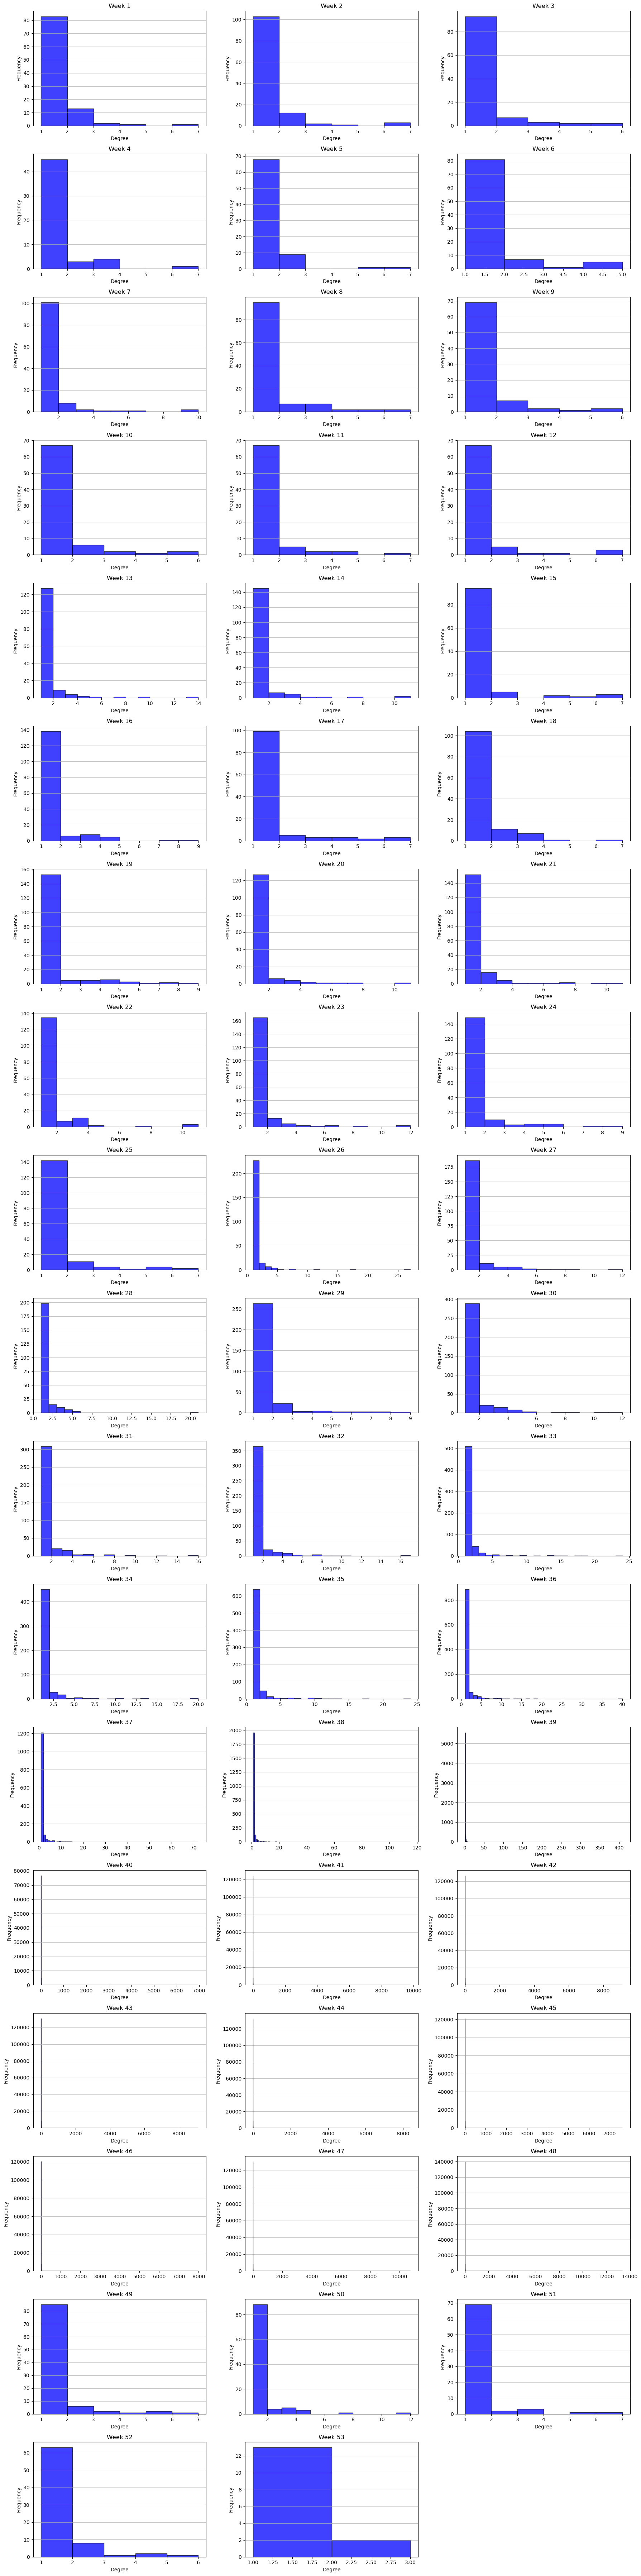

In [29]:
num_weeks = len(weekly_graphs)

#install subplot grid
num_cols = 3  # how many plots i want in each row 

num_rows = num_weeks // num_cols + (num_weeks % num_cols > 0)

plt.figure(figsize=(num_cols * 6, num_rows * 4))  # Adjust the size as needed

for i, (week, G) in enumerate(sorted(weekly_graphs.items()), start=1):
    plt.subplot(num_rows, num_cols, i)
    degrees = [G.degree(n) for n in G.nodes()]
    
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), alpha=0.75, color='blue', edgecolor='black')
    plt.title(f'Week {week}')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [25]:

def calculate_entropy(graph):
    degrees = [deg for node, deg in graph.degree()]
    # Calculate histogram of degrees
    hist, bin_edges = np.histogram(degrees, bins=range(min(degrees), max(degrees) + 2), density=True)
    # Filter out zero probabilities to avoid log(0)
    hist = hist[hist > 0]
    # Calculate entropy
    entropy = -np.sum(hist * np.log(hist))
    return entropy

weekly_entropies = {}

for week, graph in weekly_graphs.items():
    entropy = calculate_entropy(graph)
    weekly_entropies[week] = entropy
    print(f"Week {week}: Entropy = {entropy}")


Week 1: Entropy = 0.5902261214357165
Week 2: Entropy = 0.5811743942963421
Week 3: Entropy = 0.5492629513321481
Week 4: Entropy = 0.5714083975115882
Week 5: Entropy = 0.48714981261890455
Week 6: Entropy = 0.5618704865361852
Week 7: Entropy = 0.567941111307695
Week 8: Entropy = 0.7099762164312027
Week 9: Entropy = 0.6023378679845625
Week 10: Entropy = 0.589385023155195
Week 11: Entropy = 0.5446601779107617
Week 12: Entropy = 0.5626640007824487
Week 13: Entropy = 0.5869062588188397
Week 14: Entropy = 0.49079851043200823
Week 15: Entropy = 0.4835842757023744
Week 16: Entropy = 0.5695690622034281
Week 17: Entropy = 0.6377293702785253
Week 18: Entropy = 0.6024196901625206
Week 19: Entropy = 0.618301784016128
Week 20: Entropy = 0.5370139407409641
Week 21: Entropy = 0.651708280624872
Week 22: Entropy = 0.6350494672793698
Week 23: Entropy = 0.6101523645649228
Week 24: Entropy = 0.5951686496577709
Week 25: Entropy = 0.5719338703227344
Week 26: Entropy = 0.5569778041779017
Week 27: Entropy = 0.59

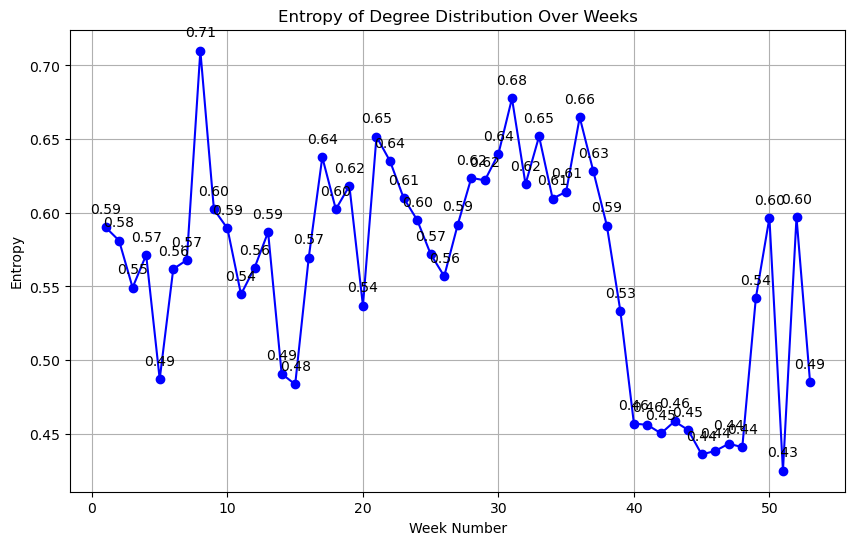

In [30]:
# Extract weeks and entropies, ensuring weeks are sorted
weeks = sorted(weekly_entropies.keys())
entropies = [weekly_entropies[week] for week in weeks]

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(weeks, entropies, marker='o', linestyle='-', color='blue')

plt.title('Entropy of Degree Distribution Over Weeks')
plt.xlabel('Week Number')
plt.ylabel('Entropy')
plt.grid(True)

# Optional: Add text labels for each point to show entropy values
for i, txt in enumerate(entropies):
    plt.annotate(f"{txt:.2f}", (weeks[i], entropies[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


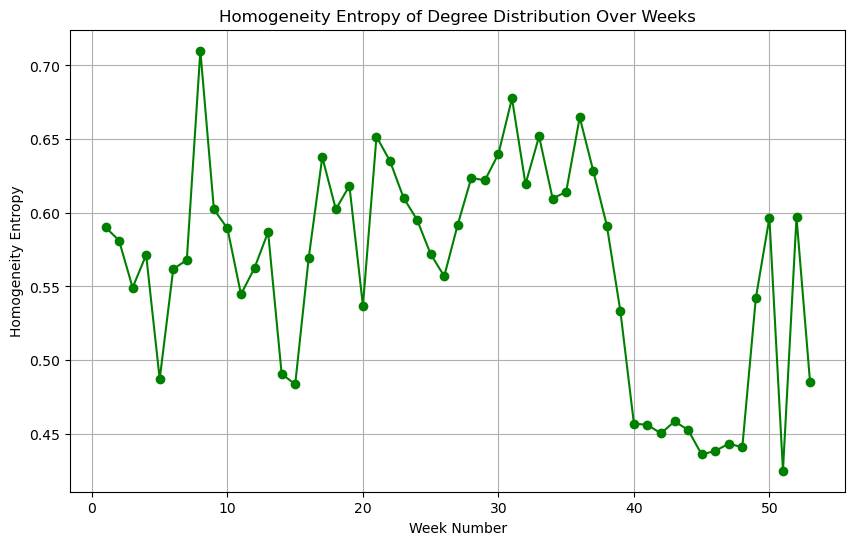

In [31]:

def calculate_homogeneity_entropy(graph):
    degrees = [deg for node, deg in graph.degree()]
    # Calculate the frequency of each degree
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probabilities = counts / counts.sum()
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

weekly_homogeneity_entropies = {}

for week, graph in weekly_graphs.items():
    entropy = calculate_homogeneity_entropy(graph)
    weekly_homogeneity_entropies[week] = entropy

# Plotting
weeks = sorted(weekly_homogeneity_entropies.keys())
homogeneity_entropies = [weekly_homogeneity_entropies[week] for week in weeks]

plt.figure(figsize=(10, 6))
plt.plot(weeks, homogeneity_entropies, marker='o', linestyle='-', color='green')
plt.title('Homogeneity Entropy of Degree Distribution Over Weeks')
plt.xlabel('Week Number')
plt.ylabel('Homogeneity Entropy')
plt.grid(True)
plt.show()


Week 44 is not fully connected.
Week 45 is not fully connected.
Week 47 is not fully connected.
Week 43 is not fully connected.
Week 46 is not fully connected.
Week 31 is not fully connected.
Week 42 is not fully connected.
Week 48 is not fully connected.
Week 36 is not fully connected.
Week 40 is not fully connected.
Week 39 is not fully connected.
Week 41 is not fully connected.
Week 32 is not fully connected.
Week 19 is not fully connected.
Week 8 is not fully connected.
Week 7 is not fully connected.
Week 6 is not fully connected.
Week 35 is not fully connected.
Week 38 is not fully connected.
Week 49 is not fully connected.
Week 37 is not fully connected.
Week 16 is not fully connected.
Week 33 is not fully connected.
Week 26 is not fully connected.
Week 25 is not fully connected.
Week 2 is not fully connected.
Week 1 is not fully connected.
Week 5 is not fully connected.
Week 34 is not fully connected.
Week 17 is not fully connected.
Week 27 is not fully connected.
Week 21 is not

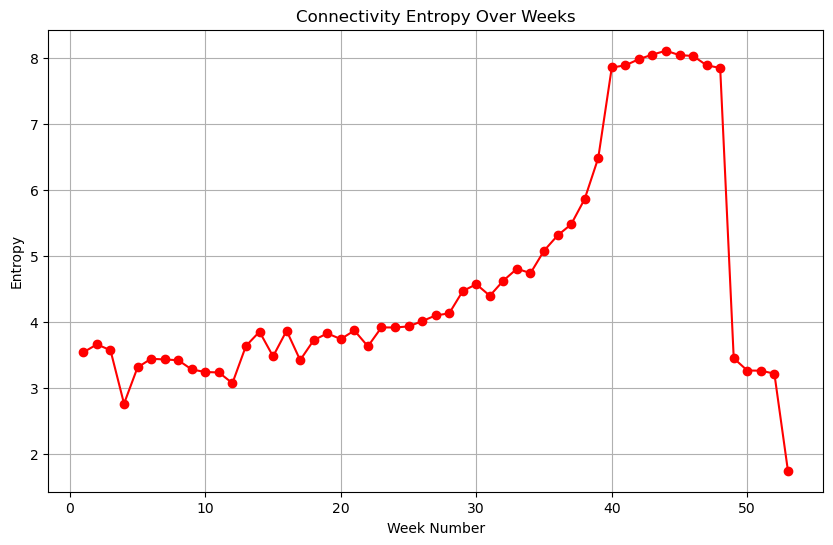

In [35]:
def check_connectivity(G):
    if nx.is_directed(G):
        return nx.is_weakly_connected(G)
    else:
        return nx.is_connected(G)

    
def calculate_connectivity_entropy(G):
    if nx.is_directed(G):
        components = nx.weakly_connected_components(G)
    else:
        components = nx.connected_components(G)
        
    component_sizes = [len(c) for c in components]    
    total_size = sum(component_sizes)   
    probabilities = [size / total_size for size in component_sizes]   
    entropy = -sum(p * np.log(p) for p in probabilities if p > 0)   
    return entropy


weekly_connectivity_entropies = {}

for week, G in weekly_graphs.items():
    if check_connectivity(G):
        print(f"Week {week} is connected.")
    else:
        print(f"Week {week} is not fully connected.")
    entropy = calculate_connectivity_entropy(G)
    weekly_connectivity_entropies[week] = entropy

# Now plot the connectivity entropy over time
weeks = sorted(weekly_connectivity_entropies.keys())
entropies = [weekly_connectivity_entropies[week] for week in weeks]

plt.figure(figsize=(10, 6))
plt.plot(weeks, entropies, marker='o', linestyle='-', color='red')
plt.title('Connectivity Entropy Over Weeks')
plt.xlabel('Week Number')
plt.ylabel('Entropy')
plt.grid(True)
plt.show()


In [36]:
import numpy as np
import networkx as nx
from scipy.stats import entropy

def calculate_degree_entropy(G):
    degrees = [deg for _, deg in G.degree()]
    degree_counts = np.bincount(degrees)
    # Normalize to get the probabilities
    degree_probabilities = degree_counts[degree_counts > 0] / sum(degree_counts)
    # Calculate the entropy
    return entropy(degree_probabilities, base=2)

weekly_degree_entropy = {week: calculate_degree_entropy(G) for week, G in weekly_graphs.items()}


In [38]:
def calculate_homogeneity_entropy(G):
    degrees = [deg for _, deg in G.degree()]
    unique_degrees = np.unique(degrees)
    homogeneity_probabilities = np.array([degrees.count(x) for x in unique_degrees]) / len(degrees)
    return entropy(homogeneity_probabilities, base=2)

weekly_homogeneity_entropy = {week: calculate_homogeneity_entropy(G) for week, G in weekly_graphs.items()}
def calculate_sentiment_connectivity_entropy(G):
    # Assuming each edge has a 'sentiment' attribute
    sentiments = nx.get_edge_attributes(G, 'sentiment')
    sentiment_values = list(sentiments.values())
    unique_sentiments = np.unique(sentiment_values)
    sentiment_probabilities = np.array([sentiment_values.count(x) for x in unique_sentiments]) / len(sentiment_values)
    return entropy(sentiment_probabilities, base=2)

weekly_sentiment_entropy = {week: calculate_sentiment_connectivity_entropy(G) for week, G in weekly_graphs.items()}


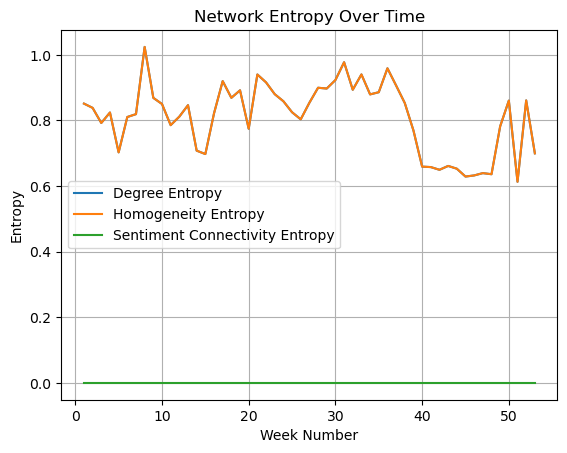

In [39]:

# Plot degree-based entropy
weeks = sorted(weekly_degree_entropy.keys())
degree_entropies = [weekly_degree_entropy[week] for week in weeks]
plt.plot(weeks, degree_entropies, label='Degree Entropy')

# Plot homogeneity-based entropy (if desired)
homogeneity_entropies = [weekly_homogeneity_entropy[week] for week in weeks]
plt.plot(weeks, homogeneity_entropies, label='Homogeneity Entropy')

# Plot sentiment-based connectivity entropy (if desired)
sentiment_entropies = [weekly_sentiment_entropy[week] for week in weeks]
plt.plot(weeks, sentiment_entropies, label='Sentiment Connectivity Entropy')

plt.xlabel('Week Number')
plt.ylabel('Entropy')
plt.title('Network Entropy Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
def calculate_sentiment_entropy(G):
    # Extract sentiment for all edges
    edge_sentiments = nx.get_edge_attributes(G, 'sentiment')
    
    # If there are no sentiments or they are not varied, return 0 entropy
    if len(set(edge_sentiments.values())) <= 1:
        return 0
    
    # Calculate the frequency of each sentiment
    sentiment_counts = list(edge_sentiments.values())
    sentiment_values, sentiment_freq = np.unique(sentiment_counts, return_counts=True)
    sentiment_probabilities = sentiment_freq / sentiment_freq.sum()
    
    # Calculate entropy using the probabilities
    return entropy(sentiment_probabilities)

# Assuming you have a dictionary of graphs for each week
sentiment_entropies = {}
for week, G in weekly_graphs.items():
    sentiment_entropy = calculate_sentiment_entropy(G)
    sentiment_entropies[week] = sentiment_entropy if sentiment_entropy is not None else 0


def calculate_sentiment_entropy2(G):
    # Extract sentiment for all edges
    edge_sentiments = nx.get_edge_attributes(G, 'sentiment')
    
    # If there are no sentiments, return None or appropriate value to indicate the issue
    if not edge_sentiments:
        return None
    
    # Calculate the frequency of each sentiment
    sentiment_counts = {}
    for sentiment in edge_sentiments.values():
        if sentiment in sentiment_counts:
            sentiment_counts[sentiment] += 1
        else:
            sentiment_counts[sentiment] = 1
    
    # Calculate the probabilities for each sentiment
    total_edges = sum(sentiment_counts.values())
    sentiment_probabilities = np.array(list(sentiment_counts.values())) / total_edges
    
    # Calculate entropy using the probabilities
    return entropy(sentiment_probabilities, base=np.e)

# Assuming you have a dictionary of graphs for each week
sentiment_entropies = {}
for week, G in weekly_graphs.items():
    sentiment_entropies[week] = calculate_sentiment_entropy(G)
        
    
def calculate_homogeneity_entropy(G):
    degrees = np.array([degree for node, degree in G.degree()])
    
    # If all nodes have the same degree, return zero
    if np.all(degrees == degrees[0]):
        return 0
    
    # Calculate the probabilities for each degree value
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    degree_probabilities = counts / degrees.size
    
    # Calculate entropy using the probabilities
    return entropy(degree_probabilities, base=np.e)

# Assuming you have a dictionary of graphs for each week
homogeneity_entropies = {}
for week, G in weekly_graphs.items():
    homogeneity_entropies[week] = calculate_homogeneity_entropy(G)
    
homogeneity_entropies = {week: calculate_homogeneity_entropy(G) for week, G in weekly_graphs.items()}


In [61]:

def calculate_degree_entropy(G):
    degrees = [G.degree(n) for n in G.nodes()]
    degree_freq = np.bincount(degrees)
    degree_prob = degree_freq / np.sum(degree_freq)  # Normalizing to create a probability distribution
    return entropy(degree_prob, base=2)  # Calculate entropy

# Apply this function to each graph for each week
degree_entropies = [calculate_degree_entropy(G) for G in weekly_graphs.values()]

def calculate_sentiment_entropy1(G):
    # Assuming each edge in G has an attribute 'sentiment' which is either 'positive', 'negative', or 'neutral'
    sentiments = nx.get_edge_attributes(G, 'sentiment').values()
    sentiment_freq = {sent: list(sentiments).count(sent) for sent in set(sentiments)}
    sentiment_prob = np.array(list(sentiment_freq.values())) / sum(sentiment_freq.values())
    return entropy(sentiment_prob, base=2)  # Calculate entropy

# Apply this function to each graph for each week
sentiment_entropies = [calculate_sentiment_entropy1(G) for G in weekly_graphs.values()]


def calculate_homogeneity_entropy1(G, attribute):
    # Assuming nodes have an 'attribute' that we're measuring homogeneity for
    attribute_values = nx.get_node_attributes(G, attribute).values()
    attribute_freq = {attr: list(attribute_values).count(attr) for attr in set(attribute_values)}
    attribute_prob = np.array(list(attribute_freq.values())) / sum(attribute_freq.values())
    return entropy(attribute_prob, base=2)  # Calculate Shannon entropy

# Example: Calculate sentiment homogeneity entropy for each graph
homogeneity_entropies = [calculate_homogeneity_entropy1(G, 'sentiment') for G in weekly_graphs.values()]


In [62]:
print(degree_entropies)
print(sentiment_entropies)
print(homogeneity_entropies)

[0.6530599105896797, 0.6290934933143397, 0.6395712354914256, 0.661461590879327, 0.6325184390797072, 0.9776038071780637, 0.6497099420779765, 0.6362121346716534, 0.9590932501523439, 0.659355429555519, 0.7694614604948774, 0.657987867007127, 0.8936711653593099, 0.8920209175728668, 1.0242791665944058, 0.8193658248005784, 0.8106077645476235, 0.8862319058337091, 0.853181636063882, 0.7823045475888639, 0.9065742271170819, 0.8217144614846631, 0.9404369146930511, 0.8035491159726829, 0.8251261584310402, 0.8384574165429798, 0.8515162983984352, 0.7028086188352813, 0.8795515385855346, 0.92004899993007, 0.8541623544043465, 0.9402163045637757, 0.9232820809040883, 0.8974142408818213, 0.8607144555334324, 0.6976646364076967, 0.7080725770759486, 0.8467267490646344, 0.899808834932158, 0.7924189360309262, 0.858646859353847, 0.7747473491952287, 0.9161827171631247, 0.8802637905444888, 0.8243680614122778, 0.8117525636155825, 0.7857785376415565, 0.8689898550809594, 0.8503028500802267, 0.869107899531334, 0.613150

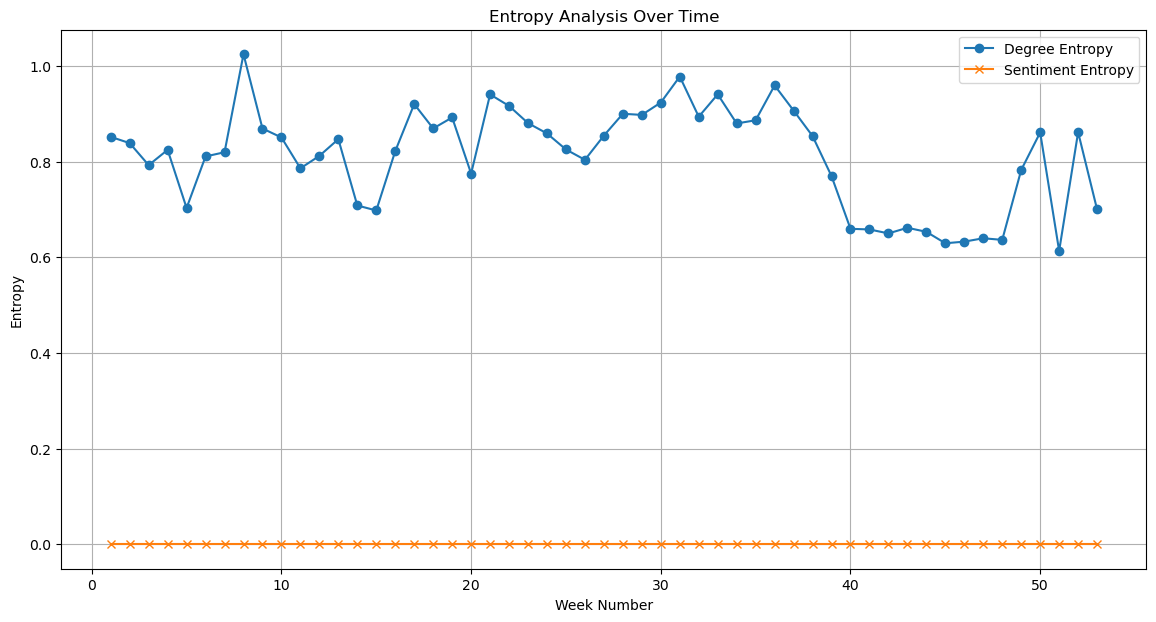

In [63]:
# Calculate entropies for each week
degree_entropies = []
sentiment_entropies = []
weeks = sorted(weekly_graphs.keys())

for week in weeks:
    G = weekly_graphs[week]
    degree_entropies.append(calculate_degree_entropy(G))
    sentiment_entropies.append(calculate_sentiment_entropy(G))

# Plotting
plt.figure(figsize=(14, 7))

# Plot degree entropy
plt.plot(weeks, degree_entropies, label='Degree Entropy', marker='o')

# Plot sentiment entropy
plt.plot(weeks, sentiment_entropies, label='Sentiment Entropy', marker='x')

plt.xlabel('Week Number')
plt.ylabel('Entropy')
plt.title('Entropy Analysis Over Time')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'list' object has no attribute 'get'

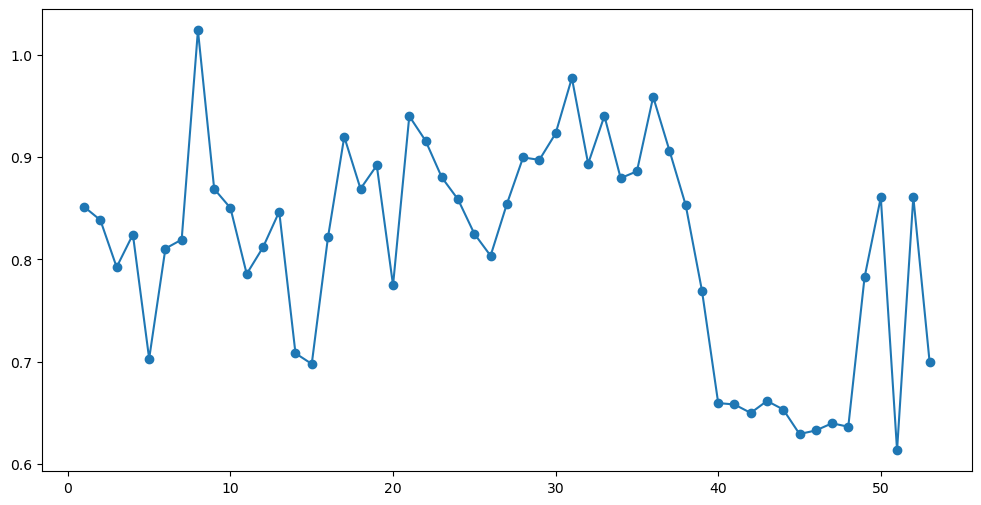

In [64]:
# Assuming that weeks, degree_entropies, sentiment_entropies, and homogeneity_entropies have been calculated
plt.figure(figsize=(12, 6))

# Plot degree entropy
plt.plot(weeks, degree_entropies, label='Degree Entropy', marker='o')

# Plot sentiment entropy
plt.plot(weeks, [sentiment_entropies.get(week, 0) for week in weeks], label='Sentiment Entropy', marker='x')

# Plot homogeneity entropy
plt.plot(weeks, [homogeneity_entropies.get(week, 0) for week in weeks], label='Homogeneity Entropy', marker='s')

plt.xlabel('Week Number')
plt.ylabel('Entropy')
plt.title('Entropy Analysis Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Assuming 'weekly_adj_matrices' contains your adjacency matrices
week = list(weekly_adj_matrices.keys())[0]  # Example: Accessing the first week

# Correctly creating a graph from a SciPy sparse matrix
G_week = nx.convert_matrix.from_scipy_sparse_matrix(weekly_adj_matrices[week], create_using=nx.DiGraph())

plt.figure(figsize=(8, 8))
nx.draw(G_week, with_labels=True, node_size=700, node_color="lightblue", arrows=True)
plt.title(f"Network Graph for Week {week}")
plt.show()


AttributeError: module 'networkx.convert_matrix' has no attribute 'from_scipy_sparse_matrix'

In [33]:
# Assuming 'weekly_adj_matrices' contains your adjacency matrices
week = list(weekly_adj_matrices.keys())[0]  # Example: Accessing the first week

# Correctly creating a graph from a SciPy sparse matrix
G_week = nx.convert_matrix.from_scipy_sparse_matrix(weekly_adj_matrices[week], create_using=nx.DiGraph())

AttributeError: module 'networkx.convert_matrix' has no attribute 'from_scipy_sparse_matrix'

In [33]:
# function to calculate sentiment score
def calculate_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Using the compound score as the sentiment score

# Apply the function to the 'text' column to create the 'sentiment_score' column
df_twcs['sentiment_score'] = df_twcs['text'].apply(calculate_sentiment_score)


# 2. Average Sentiment Score per Week
average_sentiment_per_week = df_twcs.groupby('week_number')['sentiment_score'].mean()
#average_sentiment_per_week

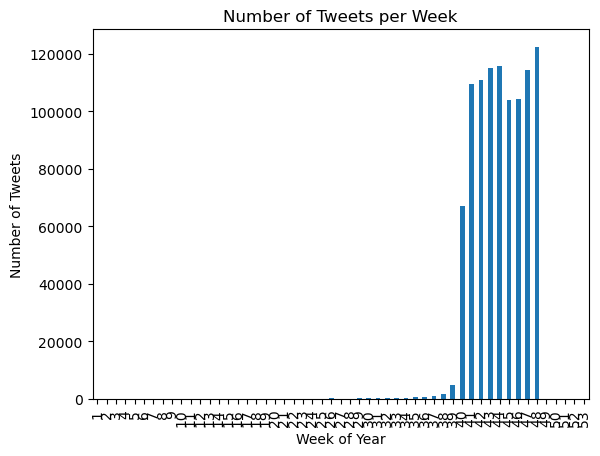

In [32]:
#Visualize Data by Week
tweets_per_week.plot(kind='bar')
plt.title('Number of Tweets per Week')
plt.xlabel('Week of Year')
plt.ylabel('Number of Tweets')
plt.show()


### For all the dataset 

### New

In [38]:


# Assuming df_twcs is your DataFrame and it has a 'created_at' column
df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], errors='coerce')  # Convert to datetime, handling errors

# Extract the ISO week number
df_twcs['week_number'] = df_twcs['created_at'].dt.isocalendar().week


In [41]:
unique_weeks = df_twcs['week_number'].unique()
unique_weeks = np.sort(unique_weeks)  
unique_weeks

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53],
      dtype=object)

In [47]:
# Get data for the first week
first_week_number = unique_weeks[0]
first_week_data = df_twcs[df_twcs['week_number'] == first_week_number]

# To process each week's data in a loop
for week_number in unique_weeks:
    week_data = df_twcs[df_twcs['week_number'] == week_number]
    
    # Process each week's data here, e.g., generate a connection matrix for the week
    # Example placeholder operation: print the number of records for the week
    print(f"Week {week_number}: {len(week_data)} records")


Week 1: 63 records
Week 2: 78 records
Week 3: 68 records
Week 4: 35 records
Week 5: 50 records
Week 6: 60 records
Week 7: 79 records
Week 8: 81 records
Week 9: 52 records
Week 10: 50 records
Week 11: 49 records
Week 12: 52 records
Week 13: 100 records
Week 14: 106 records
Week 15: 68 records
Week 16: 105 records
Week 17: 80 records
Week 18: 79 records
Week 19: 123 records
Week 20: 95 records
Week 21: 124 records
Week 22: 114 records
Week 23: 131 records
Week 24: 115 records
Week 25: 107 records
Week 26: 183 records
Week 27: 143 records
Week 28: 159 records
Week 29: 208 records
Week 30: 229 records
Week 31: 264 records
Week 32: 294 records
Week 33: 434 records
Week 34: 371 records
Week 35: 530 records
Week 36: 763 records
Week 37: 1042 records
Week 38: 1670 records
Week 39: 4833 records
Week 40: 67207 records
Week 41: 109537 records
Week 42: 110934 records
Week 43: 114933 records
Week 44: 115705 records
Week 45: 104026 records
Week 46: 104370 records
Week 47: 114315 records
Week 48: 122

In [16]:



# Assuming you want to focus on the first week of data, first find out what the earliest date is
start_date = df_twcs['created_at'].min()
# Get the week number for the start date
start_week = start_date.isocalendar()[1]

# Now, filter the DataFrame for the first week's data
first_week_data = df_twcs[df_twcs['week_of_year'] == start_week]

# If you want to normalize the week number to start from 1 for your dataset
df_twcs['normalized_week'] = df_twcs['week_of_year'] - start_week + 1

# Now, you can work with `first_week_data` which contains only the tweets from the first week in your dataset


In [19]:
first_week_data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,week_of_year,normalized_week
6113,9087,GloCare,False,2017-05-11 15:37:17,@117624 @117625 @117626 @117627 Record shows t...,9088,9089.0,19,1
6139,9089,117624,True,2017-05-11 13:54:39,@GloCare @117625 @117626 @117627 Recall this i...,9087,9114.0,19,1
6140,9114,117624,True,2017-05-11 13:53:36,@GloCare @117625 @117626 @117627 08054117690,9089,9115.0,19,1
6141,9115,GloCare,False,2017-05-11 13:49:31,@117624 @117625 @117626 @117627 Kindly provide...,9114,9116.0,19,1
6142,9116,117624,True,2017-05-11 11:12:03,@117625 @117626 @117627 @GloCare I believed GL...,9115,9117.0,19,1
...,...,...,...,...,...,...,...,...,...
2730594,2905807,AppleSupport,False,2017-05-13 20:39:30,@804670 Thank you for letting us know. How oft...,2905804,2905808.0,19,1
2730595,2905808,804670,True,2017-05-13 20:31:00,@AppleSupport Works after restarting. Ideally ...,2905807,2905809.0,19,1
2730596,2905809,AppleSupport,False,2017-05-13 20:16:28,"@804670 After you restart, let us know the res...",2905808,2905810.0,19,1
2730597,2905810,804670,True,2017-05-13 20:09:40,"@AppleSupport Hello. No, not restarted, Sierra...",2905809,2905811.0,19,1


/var/folders/b8/2pryzbwn1td3r1t1_lld8qnm0000gn/T/ipykernel_6915/3073780216.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week_data['sentiment'] = first_week_data['text'].apply(get_sentiment_category)


sentiment
Positive    53.968254
Neutral     34.920635
Negative    11.111111
Name: proportion, dtype: float64


In [37]:
# Assuming you've already added 'week_number' to df
# Find the minimum week number in your dataset to identify the first week
min_week_number = df_twcs['week_number'].min()

# Filter the DataFrame to get rows from the first week
first_week_data = df_twcs[df_twcs['week_number'] == min_week_number]

# Now, first_week_data contains all tweets from the first week of your dataset


In [41]:
# Assuming df_twcs['week_number'] has already been set using the ISO week number
min_week_number = df_twcs['week_number'].min()

# Filter the DataFrame to only include rows from the first week
first_week_data = df_twcs[df_twcs['week_number'] == min_week_number]

# Now, first_week_data contains all tweets from the first week.


df_twcs

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,week_of_year,normalized_week,week_number
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0,44,26,44
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,44,26,44
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0,44,26,44
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,44,26,44
5,6,sprintcare,False,2017-10-31 21:46:24,@115712 Can you please send us a private messa...,"5,7",8.0,44,26,44
...,...,...,...,...,...,...,...,...,...,...
2811718,2987897,VirginTrains,False,2017-11-22 06:57:43,"@136417 Sorry to hear that James, did the the ...",2987898,2987899.0,47,29,47
2811728,2987907,nationalrailenq,False,2017-11-30 07:38:44,London bound trains on the route between Broml...,2987906,2987908.0,48,30,48
2811736,2987915,CoxHelp,False,2017-11-30 07:27:11,"@823858 Hello, this does not sound good. Can...",2987916,2987917.0,48,30,48
2811739,2987918,ArgosHelpers,False,2017-11-30 07:58:42,@823859 Hi Natalie that doesn't sound good. Ca...,2987919,2987920.0,48,30,48


In [42]:
#3. Constructing the Connection Matrix

# Initialize a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in edge_list.iterrows():
    G.add_edge(row['author_id'], row['in_response_to_tweet_id'])
#4. Analyzing the Graph
# Convert to adjacency matrix (be cautious with large graphs)
adj_matrix = nx.adjacency_matrix(G)
dense_matrix = adj_matrix.todense()

# Print the dense matrix
print(dense_matrix)


[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [44]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get the sentiment category
def get_sentiment_category(text):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to your DataFrame
first_week_data['sentiment'] = first_week_data['text'].apply(get_sentiment_category)
print(df_twcs)
# Now, 'sentiment' column contains the sentiment category for each tweet
sentiment_counts = first_week_data['sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)




         tweet_id        author_id  inbound          created_at  \
0               1       sprintcare    False 2017-10-31 22:10:47   
2               3           115712     True 2017-10-31 22:08:27   
3               4       sprintcare    False 2017-10-31 21:54:49   
4               5           115712     True 2017-10-31 21:49:35   
5               6       sprintcare    False 2017-10-31 21:46:24   
...           ...              ...      ...                 ...   
2811718   2987897     VirginTrains    False 2017-11-22 06:57:43   
2811728   2987907  nationalrailenq    False 2017-11-30 07:38:44   
2811736   2987915          CoxHelp    False 2017-11-30 07:27:11   
2811739   2987918     ArgosHelpers    False 2017-11-30 07:58:42   
2811760   2811285   Safaricom_Care    False 2017-11-22 07:13:34   

                                                      text response_tweet_id  \
0        @115712 I understand. I would like to assist y...                 2   
2        @sprintcare I have sent se

/var/folders/b8/2pryzbwn1td3r1t1_lld8qnm0000gn/T/ipykernel_6915/637272039.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week_data['sentiment'] = first_week_data['text'].apply(get_sentiment_category)


In [ ]:

# First, ensure 'created_at' is in datetime format
df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

# Then, create a new column for the week number
# If you want the ISO week number:
df_twcs['week_number'] = df_twcs['created_at'].dt.isocalendar().week

# Alternatively, if you prefer the week number according to the US system (where the week starts on Sunday):
df_twcs['week_number_us'] = df_twcs['created_at'].dt.week

# Now, df includes a 'week_number' column with the ISO week number for each tweet


### Text Preprocessing:



In [11]:

# Tokenization
df_twcs['text'] = df_twcs['text'].apply(lambda x: word_tokenize(x.lower()))

# Stop word removal
stop_words = set(stopwords.words('english'))
df_twcs['text'] = df_twcs['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming (or Lemmatization)
stemmer = PorterStemmer()

df_twcs['text'] = df_twcs['text'].apply(lambda tokens: [word.lower() for word in tokens])


In [12]:
df_twcs['text']

0          [@, 115712, understand, ., would, like, assist...
2          [@, sprintcare, sent, several, private, messag...
3          [@, 115712, please, send, us, private, message...
4                                         [@, sprintcare, .]
5          [@, 115712, please, send, us, private, message...
                                 ...                        
2811718    [@, 136417, sorry, hear, james, ,, staff, made...
2811728    [london, bound, trains, route, bromley, south,...
2811736    [@, 823858, hello, ,, sound, good, ., dm, acco...
2811739    [@, 823859, hi, natalie, n't, sound, good, ., ...
2811760    [@, 783956, hi, ,, apologies, inconvenience, ....
Name: text, Length: 976810, dtype: object

# Feature Engineering:

1. Text Features:
2. Temporal Features:
3. Categorical Features:
4. Text-Based Features (NLP):
5. Interaction Features:
6. Domain-Specific Features:
7. Feature Scaling:
8. Feature Selection:


In [13]:
# 1. Text Features:
# A. Text Length: Create a feature that represents the length of the text in characters or words.
df_twcs['text_length'] = df_twcs['text'].apply(len)
#print(df_twcs['text_length'])

# B. Word Count: Count the number of words in each text.
df_twcs['word_count'] = df_twcs['text'].apply(lambda tokens: len(tokens))

print(df_twcs['word_count'])


0          16
2           9
3          16
4           3
5          12
           ..
2811718    15
2811728    25
2811736    19
2811739    17
2811760    15
Name: word_count, Length: 976810, dtype: int64


#2. Features of Temporal Order:

# A. Extracting Date and Time: Parse 'created_at' if it is in a string format to extract relevant temporal information such as month, day, hour, and so on.

#df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'])
df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], utc=True)


df_twcs['year'] = df_twcs['created_at'].dt.year
df_twcs['month'] = df_twcs['created_at'].dt.month

# B. Time Since Tweet: Calculate the time elapsed since a tweet was posted relative to a reference date.
#reference_date = pd.Timestamp('2024-01-31')
reference_date = pd.Timestamp('2024-01-31', tz='UTC')
df_twcs['time_since_posted'] = (reference_date - df_twcs['created_at']).dt.total_seconds()




In [ ]:
# 3. Categorical Features:
# Encoding Categorical Variables: Convert categorical variables like 'author_id' into numerical values using techniques like one-hot encoding or label encoding.

df_twcs = pd.get_dummies(df_twcs, columns=['author_id'], prefix='author')


In [ ]:


# 4. Text-Based Features (NLP):
# A. TF-IDF: Compute TF-IDF scores for words in the text to represent their importance.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_twcs['text'])

# B. Word Embeddings: Use pre-trained word embeddings (e.g., Word2Vec, GloVe) to convert text into dense vectors.

# Load pre-trained Word2Vec model
word2vec_model = Word2Vec.load('word2vec.model')

def text_to_embedding(text):
    words = text.split()
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

df_twcs['text_embedding'] = df_twcs['text'].apply(text_to_embedding)


In [ ]:
# 5. Interaction Features:
# Create interaction features by combining existing features.

df_twcs['text_length_word_count_ratio'] = df_twcs['text_length'] / df_twcs['word_count']



In [ ]:
# 6. Domain-Specific Features:

# If you have domain-specific knowledge, create features that are relevant to your specific problem.



In [ ]:
#7. Feature Scaling:

# Normalize or scale numerical features if needed using techniques like Min-Max scaling or Standardization.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_twcs[['text_length', 'word_count']] = scaler.fit_transform(df_twcs[['text_length', 'word_count']])




In [ ]:
# 8. Feature Selection:

# Perform feature selection techniques (e.g., Recursive Feature Elimination, feature importance from tree-based models) to choose the most relevant features for your model.


In [ ]:


# # Feature Engineering:
# 
# 1. Text Features:
# 2. Temporal Features:
# 3. Categorical Features:
# 4. Text-Based Features (NLP):
# 5. Interaction Features:
# 6. Domain-Specific Features:
# 7. Feature Scaling:
# 8. Feature Selection:


# C. Presence of Keywords: Create binary features indicating the presence of specific keywords in the text.
keywords = ['important', 'urgent', 'help']
for keyword in keywords:
    df_twcs[keyword + '_present'] = df_twcs['text'].apply(lambda x: 1 if keyword in x else 0)





inbound_chat = df_twcs[df_twcs.inbound]

inbound_chat


# In[14]:


df_in_outs = pd.merge(inbound_chat, df_twcs, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

df_in_outs


# In[15]:


class Preprocess_Dataset:
    def __init__(self, dataframe):
        self.df = dataframe
        self.last_id = 0
        self.conv = []
        self.company_name = ''
        self.df_convs = pd.DataFrame(columns=['author_id', 'company_name', 'dialog'])
        
    def add_to_df(self, last_id, author_id, company_name, text_x, text_y):
        if (last_id == author_id):
            self.conv.append('participant1|'+ " ".join(filter(lambda x:x[0]!='@', text_x.split())))
            self.conv.append('participant2|'+ " ".join(filter(lambda x:x[0]!='@', text_y.split())))
        elif self.last_id != 0:
            if len(self.conv) > 0:
                id = len(self.df_convs)
                self.df_convs.loc[id, 'author_id'] = self.last_id
                self.df_convs.loc[id, 'company_name'] = self.company_name
                self.df_convs.loc[id, 'dialog'] = self.conv
                self.conv = []
            self.last_id = author_id
            
        else:
            self.conv.append('participant1|'+ text_x)
            self.conv.append('participant2|'+ text_y)
            self.last_id = author_id
            self.company_name = company_name
    def create_df(self):
        [self.add_to_df(self.last_id, row[0], row[1], row[2], row[3]) for row in self.df[['author_id_x', 'author_id_y','text_x', 'text_y']].values]
        return self.df_convs


# In[16]:


def clean_text(text):
    clean_text = []
    text = re.sub("''", "", text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split())) # Remove the words starts with '@'
    text = re.sub("(\\d|\\W)+"," ", text)
    clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) 
                  if (word not in stop_words and word not in list(string.punctuation))]
    return clean_text
    #return " ".join([word for word in clean_text])


# In[17]:


def split_participants(conversation):
    part1_dialog = []
    part2_dialog = []
    conv_token = []
    for conv in conversation:
        dialog = conv.split('|')
        if dialog[0] == 'participant1':
            part1_dialog.append(dialog[1])
        else:
            part2_dialog.append(dialog[1])
            
    if (len(part1_dialog) > 0):
        part1_str = " ".join([word for word in part1_dialog])
        conv_token.append(clean_text(part1_str))
    if (len(part2_dialog) > 0):
        part2_str = " ".join([word for word in part2_dialog])
        conv_token.append(clean_text(part2_str))
    return conv_token


# In[ ]:






In [ ]:


# Assuming df_twcs is your DataFrame and it has a 'created_at' column with timestamps
df_twcs['created_at'] = pd.to_datetime(df_twcs['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_twcs['week_of_year'] = df_twcs['created_at'].dt.isocalendar().week
#Step 2 & 3: Iterate Through Each Week and Filter Data


unique_weeks = df_twcs['week_of_year'].unique()
# Convert to a NumPy array and sort
unique_weeks = np.sort(unique_weeks)

# Placeholder for your matrices or any other week-specific analysis results
weekly_matrices = {}

for week in unique_weeks:
    # Filter the DataFrame for the current week
    week_data = df_twcs[df_twcs['week_of_year'] == week]
    
    # Assuming 'author_id' and 'in_response_to_tweet_id' represent the connections
    # Prepare your edge list here based on week_data
    # This is a simplistic representation; adjust according to your actual data structure
    edge_list = week_data[['author_id', 'in_response_to_tweet_id']].dropna()
    
    # You can now create a graph or a matrix based on the edge_list
    # For demonstration, let's assume we're creating a simple adjacency matrix
    # The actual implementation will depend on the specific details of your data and analysis needs
    
    # Example: Creating a graph (using NetworkX or a similar library might be more efficient for large datasets)
    # import networkx as nx
    # G = nx.from_pandas_edgelist(edge_list, 'author_id', 'in_response_to_tweet_id', create_using=nx.DiGraph)
    # Now, G is your graph for the week, and you can perform further analysis or convert it into a matrix
    
    # Store the graph or matrix in the dictionary, keyed by week
    # weekly_matrices[week] = G  # Or your matrix
    
    # For demonstration, let's print the size of the DataFrame for each week
    print(f"Week {week}: {len(week_data)} tweets")
